In [2]:
import pandas as pd
import numpy as np

# from numpyro.infer import MCMC, NUTS, Predictive

import pickle 
from scipy.stats import linregress
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import arviz as az

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [250]:

import pandas as pd
import numpy as np
import pyro.distributions as dist
import networkx as nx
import pickle

## Simulate some data
class DataSimulator:
    def __init__(self):
        self.number_nodes = None
        self.network = None
        self.sim_parameters = None
        self.protein_mu = None
        self.ordered_nodes = None

    def generate_graph(self, n, seed=69):

        if n > 2:
            connected_graph = nx.gnp_random_graph(n, 0.25, directed=True, seed=seed)
            dag = nx.DiGraph([(u,v,{'weight' : np.random.randint(-10,10)}) for (u,v)
                              in connected_graph.edges() if u<v])
        else:
            connected_graph = nx.gnp_random_graph(n, 1., directed=True, seed=seed)
            dag = nx.DiGraph([(u, v, {'weight': np.random.randint(-10, 10)}) for (u, v)
                              in connected_graph.edges() if u < v])

        self.number_nodes = len(dag.nodes)
        self.network = dag

    def ground_truth_values(self):

        protein_mean = dict()

        nodes = list(nx.topological_sort(self.network))
        self.ordered_nodes = nodes
        for i in range(len(nodes)):

            intercept = dist.Uniform(15., 25.).sample()

            in_edges = list(self.network.in_edges(nodes[i]))

            if len(in_edges) == 0:
                mu = intercept
            else:
                beta_list = list()

                for j in range(len(in_edges)):
                    coef = dist.Uniform(-.25, .25).sample()
                    beta_list.append(coef*protein_mean[in_edges[j][0]])

                mu = intercept + sum(np.array(beta_list))

            protein_mean[nodes[i]] = mu

        self.protein_mu = protein_mean

    def id_no_impute(self, data, parameters):

        ## Get runs with all missing values
        missing_runs = data["Intensity"].isnull().groupby(
            [data["Protein"], data["Run"]]).sum().reset_index()

        total_obs = parameters["Features"]
        missing_runs = missing_runs.loc[missing_runs["Intensity"] == total_obs]


        ## Get features with at least 2 obs
        missing_features = data["Intensity"].isnull().groupby(
            [data["Protein"], data["Feature"]]).sum().reset_index()
        total_runs = parameters["Replicate"]
        missing_features = missing_features.loc[missing_features["Intensity"] > total_runs-2]

        data.loc[:, "Impute"] = 1
        impute_data=data

        if len(missing_runs) > 0:
            missing_runs.loc[:, "Impute"] = 0
            impute_data = pd.merge(impute_data, missing_runs.loc[:, ["Protein", "Run", "Impute"]], how="left",
                                  on=["Protein", "Run"])
            impute_data.loc[:, "Impute"] = np.where(np.isnan(impute_data.loc[:, "Impute_y"]),
                                                    impute_data.loc[:, "Impute_x"],
                                                    impute_data.loc[:, "Impute_y"])
            impute_data = impute_data.drop(columns=["Impute_x", "Impute_y"])

        if len(missing_features) > 0:
            missing_features.loc[:, "Impute"] = 0
            impute_data = pd.merge(impute_data, missing_features.loc[:, ["Protein", "Feature", "Impute"]], how="left",
                                  on=["Protein", "Feature"])
            impute_data.loc[:, "Impute"] = np.where(np.isnan(impute_data.loc[:, "Impute_y"]),
                                                    impute_data.loc[:, "Impute_x"],
                                                    impute_data.loc[:, "Impute_y"])
            impute_data = impute_data.drop(columns=["Impute_x", "Impute_y"])

        return impute_data

    def simulate_data(self, num_proteins, num_reps, num_features, mar_thresh=.05):

        self.generate_graph(num_proteins)

        self.sim_parameters = {"Proteins" : self.number_nodes,
                               "Replicate" : num_reps,
                               "Features" : num_features,
                               "MAR" : mar_thresh}

        self.ground_truth_values()

        sim_data = pd.DataFrame()

        ## replicate effect
        ## TODO: should this be same for all proteins or not?
        ## TODO: pick either numpy or pyro for sampling
        rep_effect = np.random.uniform(-2, 2, num_reps - 1)
        last_val = -sum(rep_effect)
        rep_effect = rep_effect.tolist()
        rep_effect.append(last_val)

        ## Generate data
        row = 0
        for n in range(self.number_nodes):

            sigma = dist.Uniform(.1, .5).sample()
            for f in range(num_features):
                feat_effect = dist.Normal(0., 1.5).sample()

                for r in range(num_reps):
                    mu = self.protein_mu[self.ordered_nodes[n]] + rep_effect[r] + feat_effect
                    val = dist.Normal(mu, sigma).sample()

                    sim_data.loc[row, "Intensity"] = float(val)
                    sim_data.loc[row, "True_Intensity"] = float(val)
                    sim_data.loc[row, "Run"] = r
                    sim_data.loc[row, "Protein"] = self.ordered_nodes[n]
                    sim_data.loc[row, "Feature"] = f
                    sim_data.loc[row, "True_mean"] = float(mu)
                    sim_data.loc[row, "True_std"] = float(sigma)
                    sim_data.loc[row, "Protein_mean"] = self.protein_mu[self.ordered_nodes[n]].detach().numpy()
                    sim_data.loc[row, "Run_effect"] = rep_effect[r]
                    sim_data.loc[row, "Feature_effect"] = feat_effect.detach().numpy()

                    row += 1

        for i in range(len(sim_data)):
            mar_prob = np.random.uniform(0, 1)
            mnar_prob = np.random.uniform(0, 1)

            mnar_thresh = 1 / (1 + np.exp(-6.5 + (.4 * sim_data.loc[i, "True_Intensity"])))
            sim_data.loc[i, "MNAR_threshold"] = mnar_thresh

            if mar_prob < mar_thresh:
                sim_data.loc[i, "Intensity"] = np.nan
                sim_data.loc[i, "MAR"] = True
            else:
                sim_data.loc[i, "MAR"] = False

            if mnar_prob < mnar_thresh:
                sim_data.loc[i, "Intensity"] = np.nan
                sim_data.loc[i, "MNAR"] = True
            else:
                sim_data.loc[i, "MNAR"] = False

        sim_data.loc[:, "Missing"] = np.isnan(sim_data["Intensity"]) * 1

        sim_data = self.id_no_impute(sim_data, self.sim_parameters)
        self.data = sim_data


## Load data

In [241]:
with open(r"../model_code/data/simulated_data_two.pickle", "rb") as input_file:
    simulator = pickle.load(input_file)

In [245]:
with open(r"../model_code/data/az_mcmc_causal_two.pickle", "rb") as input_file:
    mcmc = pickle.load(input_file)
    
with open(r"../model_code/data/az_run_mcmc_causal_two.pickle", "rb") as input_file:
    mcmc_run = pickle.load(input_file)

## Analyze model stats

array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'mar'}>,
        <AxesSubplot:title={'center':'mar'}>]], dtype=object)

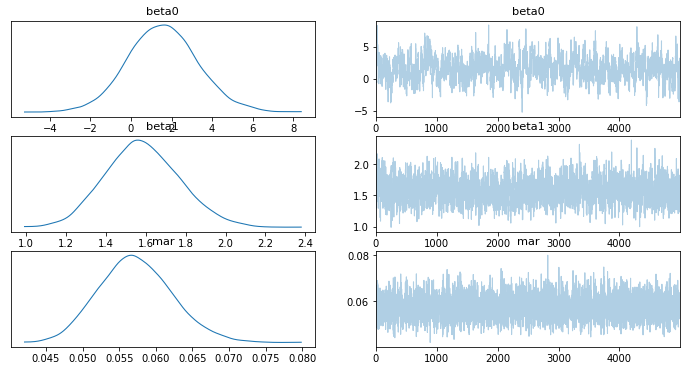

In [246]:
az.plot_trace(mcmc, var_names=["beta0", "beta1", "mar"])

array([[<AxesSubplot:title={'center':'bC_1_0'}>,
        <AxesSubplot:title={'center':'bC_1_0'}>]], dtype=object)

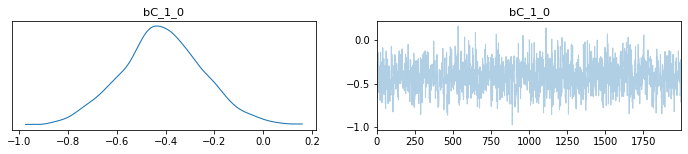

In [247]:
az.plot_trace(mcmc_run, var_names=[i for i in list(mcmc_run.to_dict()['posterior'].keys()) if "bC" in i])

array([[<AxesSubplot:title={'center':'mu_0'}>,
        <AxesSubplot:title={'center':'mu_0'}>],
       [<AxesSubplot:title={'center':'mu_1'}>,
        <AxesSubplot:title={'center':'mu_1'}>]], dtype=object)

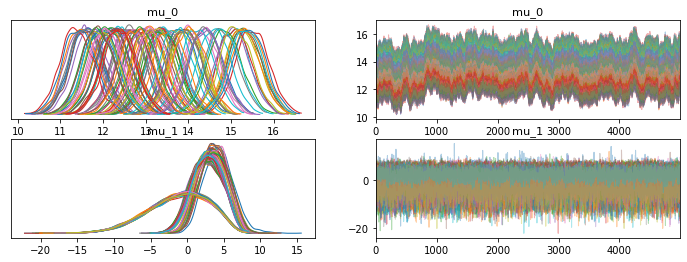

In [248]:
az.plot_trace(mcmc, var_names=["mu_{}".format(i) for i in range(2)])

array([[<AxesSubplot:title={'center':'run_imp_1'}>,
        <AxesSubplot:title={'center':'run_imp_1'}>]], dtype=object)

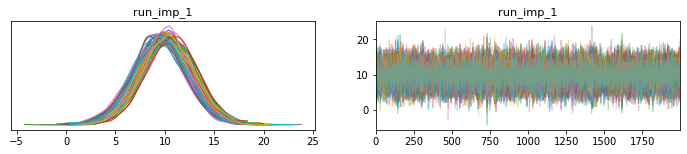

In [239]:
az.plot_trace(mcmc_run, var_names=["run_imp_1"])

Text(0.5, 0, 'Intensity')

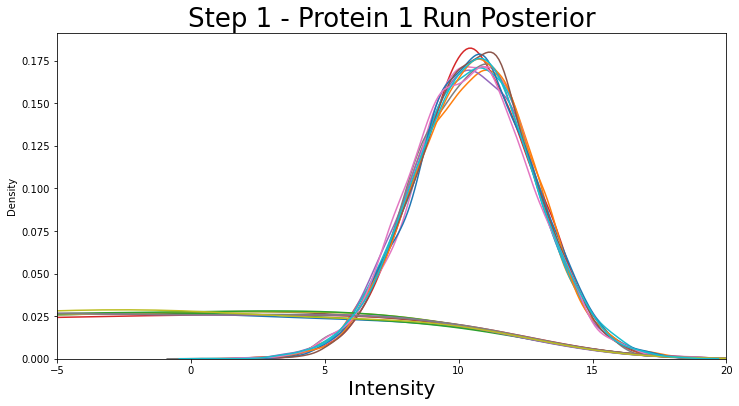

In [240]:
fig, ax = plt.subplots(figsize=(12,6))
idx = 0
for i in range(20):    
    sns.kdeplot(mcmc.posterior["mu_1"].values[0][:, i], ax=ax)
    
ax.set_xlim(-5,20)

ax.set_title("Step 1 - Protein 1 Run Posterior".format(4), size=26)
ax.set_xlabel("Intensity", size=20)

Text(0.5, 0, 'Intensity')

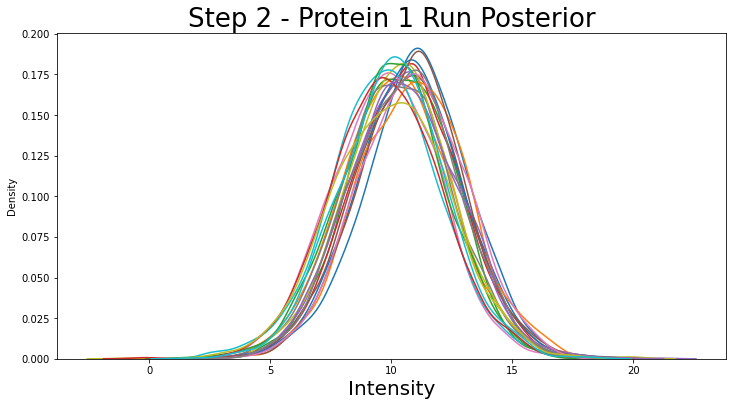

In [233]:
fig, ax = plt.subplots(figsize=(12,6))
idx = 0
for i in range(20):    
    std_test = mcmc.posterior["mu_1"].values[0][:, i].std()

    if std_test < 2:
        sns.kdeplot(mcmc.posterior["mu_1"].values[0][:, i], ax=ax)
    else:
        sns.kdeplot(mcmc_run.posterior["run_imp_1"].values[0][:, idx], ax=ax)
        idx+=1
        
# ax.set_xlim(-8,9)

ax.set_title("Step 2 - Protein 1 Run Posterior".format(4), size=26)
ax.set_xlabel("Intensity", size=20)

In [211]:
real_data = simulator.data[(simulator.data["Protein"] == 0)].reset_index(drop=True)

imp_results_list = list()

for i in range(len(simulator.data["Protein"].unique())):
    idx=0
    real_data = simulator.data[(simulator.data["Protein"] == i)].reset_index(drop=True)
    for r in range(len(simulator.data["Run"].unique())):
        run_gt = real_data.loc[real_data["Run"] == r]["Run_Protein_mean"].unique()
        
        data = mcmc.posterior["mu_{}".format(i)][0][:,r]
        mean = data.median().values
        std = data.std().values
        if std > 2:
            data = mcmc_run.posterior["run_imp_{}".format(i)].values[0][:, idx]
            mean = data.mean()
            std = data.std()
            idx+=1
        error = mean - run_gt
        imp_results_list.append(pd.DataFrame({"Protein": i, "Run": r, 
                                              "mean": mean, "std": std,
                                              "true_val":run_gt,
                                              "error": error}))


imp_results = pd.concat(imp_results_list)

<AxesSubplot:ylabel='Density'>

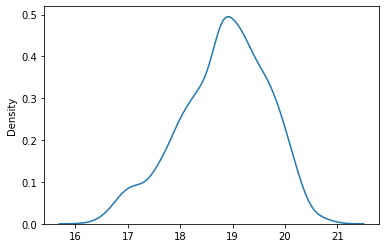

In [212]:
sns.kdeplot(mcmc.posterior["mu_0"].values[0][:, 0])

In [225]:
imp_results

Protein  Run       mean       std   true_val     error
0        0    0  18.894062  0.839853  20.503919 -1.609857
0        0    1  19.377228  0.841548  21.101479 -1.724251
0        0    2  19.287457  0.839545  20.954367 -1.666911
0        0    3  18.339821  0.840087  20.116203 -1.776382
0        0    4  19.611393  0.840293  21.199459 -1.588066
0        0    5  18.136505  0.838312  19.830565 -1.694059
0        0    6  20.394068  0.838122  21.928134 -1.534067
0        0    7  19.917225  0.839829  21.641935 -1.724710
0        0    8  20.630747  0.840013  22.192164 -1.561417
0        0    9  18.785568  0.839871  20.501137 -1.715569
0        0   10  19.499722  0.843015  21.209240 -1.709519
0        0   11  18.816572  0.841605  20.370106 -1.553534
0        0   12  18.232559  0.840355  19.994536 -1.761977
0        0   13  20.680801  0.843356  22.248251 -1.567450
0        0   14  20.782118  0.843220  22.516772 -1.734655
0        0   15  18.360853  0.852772  20.222783 -1.861930
0        0   16  18.273327  0.838876  19.977747 -1.704420
0        0   17  18.921741  0.838557  20.681264 -1.759522
0        0   18  20.149803  0.840953  21.765589 -1.615785
0        0   19  18.075218  0.840976  19.671657 -1.596439
0        0   20  19.833969  0.841384  21.327906 -1.493937
0        0   21  18.963854  0.839121  20.533656 -1.569803
0        0   22  20.609009  0.839043  22.378409 -1.769401
0        0   23  19.151157  0.840308  20.780809 -1.629652
0        0   24  18.181187  0.839048  19.918265 -1.737078
0        0   25  20.323792  0.843357  22.100967 -1.777176
0        0   26  19.024967  0.842221  20.646684 -1.621717
0        0   27  21.541454  0.840809  23.216194 -1.674740
0        0   28  20.325920  0.841907  22.050960 -1.725040
0        0   29  19.347359  0.841119  20.848527 -1.501168
0        0   30  17.917747  0.841110  19.529587 -1.611840
0        0   31  21.611877  0.839219  23.117414 -1.505537
0        0   32  21.130581  0.840081  22.788147 -1.657566
0        0   33  17.865082  0.843329  19.455833 -1.590751
0        0   34  20.728975  0.837618  22.406116 -1.677140
0        0   35  18.637321  0.838179  20.183506 -1.546185
0        0   36  20.364983  0.839220  21.975106 -1.610123
0        0   37  19.584721  0.840973  21.037498 -1.452777
0        0   38  20.610886  0.837003  22.217023 -1.606137
0        0   39  18.452196  0.841693  20.129256 -1.677060
0        0   40  20.091433  0.840943  21.964413 -1.872980
0        0   41  20.757504  0.838737  22.504428 -1.746925
0        0   42  18.828321  0.842289  20.509650 -1.681329
0        0   43  18.004395  0.840770  19.760970 -1.756576
0        0   44  21.268263  0.842032  22.876545 -1.608283
0        0   45  20.953587  0.839999  22.557308 -1.603721
0        0   46  19.603397  0.839832  21.172439 -1.569041
0        0   47  20.903145  0.841182  22.558883 -1.655738
0        0   48  18.542469  0.841163  20.259466 -1.716997
0        0   49  19.833536  0.842324  21.431757 -1.598221
0        1    0  11.288239  0.851352  11.717599 -0.429360
0        1    1  13.763727  0.876506  14.266479 -0.502751
0        1    2  12.200730  0.856831  12.380643 -0.179913
0        1    3  13.511657  0.859109  14.143937 -0.632280
0        1    4  11.560458  1.246813  13.549473 -1.989015
0        1    5  13.172369  0.860815  13.720821 -0.548452
0        1    6  12.246820  0.867942  12.896869 -0.650049
0        1    7  11.671331  1.270189  13.662477 -1.991145
0        1    8  10.784830  1.232924  14.522918 -3.738088
0        1    9  13.034083  0.840514  13.628301 -0.594218
0        1   10  14.219361  0.863708  15.150137 -0.930776
0        1   11  12.083879  1.280400  13.042769 -0.958890
0        1   12  14.525953  0.863734  15.338142 -0.812189
0        1   13  10.926310  0.875833  11.445909 -0.519599
0        1   14  10.222917  1.311460  12.272317 -2.049400
0        1   15  11.389689  0.842646  11.948231 -0.558541
0        1   16  12.435389  0.877423  13.210237 -0.774849
0        1   17  12.883485  0.841074  13.554712 -0.671227
0

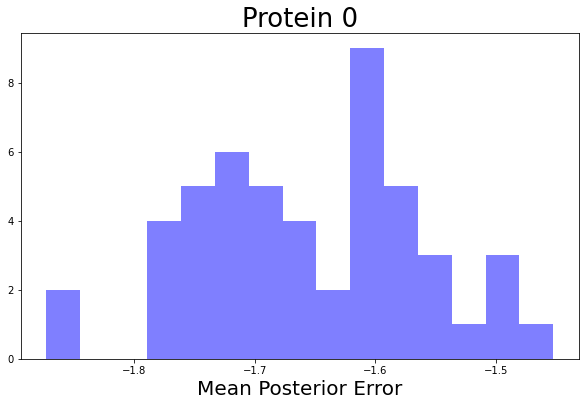

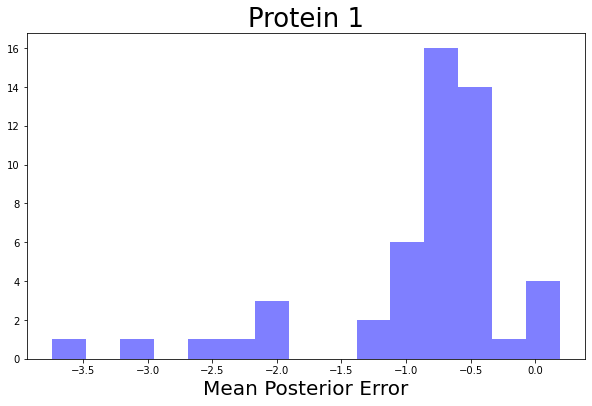

In [214]:
for i in range(len(simulator.data["Protein"].unique())):
    fig,ax = plt.subplots(figsize=(10,6))
    ax.hist(imp_results[imp_results["Protein"] == i]["error"], bins=15, color="blue", alpha=.5, label="normal")
    ax.set_title("Protein {}".format(i), size=26)
    ax.set_xlabel("Mean Posterior Error", size=20)

/home/devonjkohler/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/devonjkohler/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/devonjkohler/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

9.061014
0.9200158
0.6176435
0.07507158
0.082815036
0.017787576


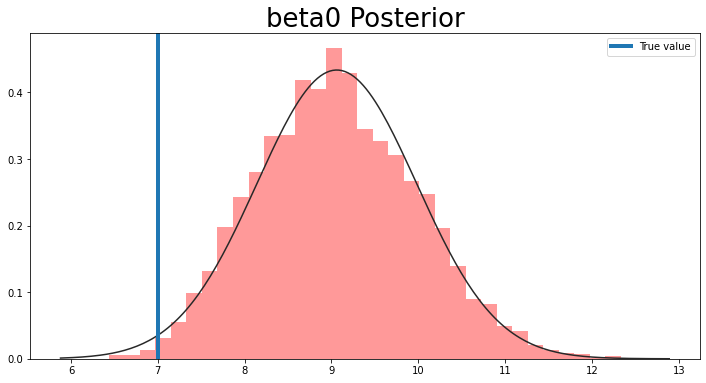

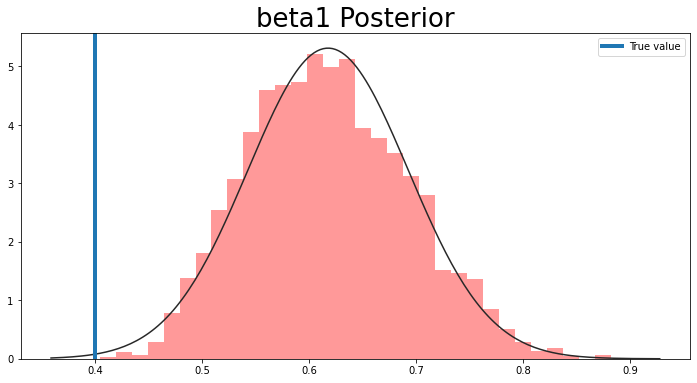

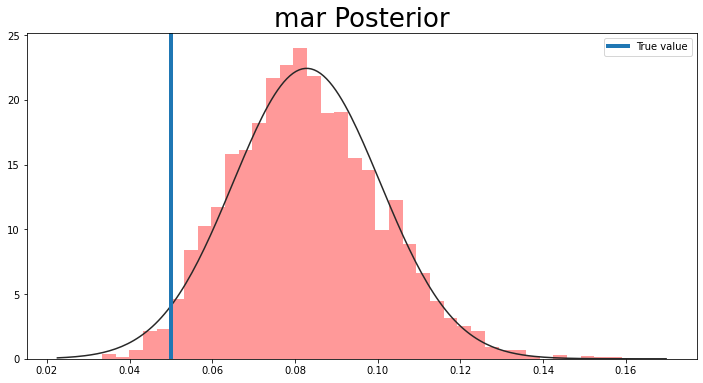

In [166]:
true_vals = [7., .4, .05]
idx=0
for i in ["beta0", "beta1", "mar"]:
    fig, ax = plt.subplots(figsize=(12,6))

    sns.distplot(mcmc.posterior[i].values[0], fit=scipy.stats.norm, kde=False, hist=True, color='r', ax=ax)
    ax.axvline(true_vals[idx], lw = 4, label="True value")
    idx+=1
    ax.set_title("{} Posterior".format(i), size=26)
    plt.legend()
    print(mcmc.posterior[i].values[0].mean())
    print(mcmc.posterior[i].values[0].std())

In [34]:
dist = scipy.stats.norm(12, 0.40309897)
dist.ppf(.05)
dist.ppf(.95)

dist_beta1 = scipy.stats.norm(1.5, .025429543)
dist_beta1.ppf(.05)
dist_beta1.ppf(.95)

0.6418278760352684

In [1]:
fig, ax = plt.subplots(figsize=(12,8))

gt_logit = [1 / (1 + np.exp(-3 + (.2 * i))) for i in np.arange(0,30,.1)]
inf_logit = [1 / (1 + np.exp(-12+ (1.5 * i))) for i in np.arange(0,30,.1)]
inf_logit_lower = [1 / (1 + np.exp(-dist.ppf(.05) + (dist_beta1.ppf(.05) * i))) for i in np.arange(0,30,.1)]
inf_logit_upper = [1 / (1 + np.exp(-dist.ppf(.95) + (dist_beta1.ppf(.95) * i))) for i in np.arange(0,30,.1)]

ax.plot(np.arange(0,30,.1), inf_logit, color="red", lw=3, label="inferred curve")
ax.plot(np.arange(0,30,.1), inf_logit_lower, color="orange", label="inferred confidence interval")
ax.plot(np.arange(0,30,.1), inf_logit_upper, color="orange")
plt.fill_between(np.arange(0,30,.1), inf_logit_lower, inf_logit_upper, color='orange')
ax.plot(np.arange(0,30,.1), gt_logit, lw=3, label="ground truth curve")
ax.set_title("MNAR Logit Curve", size=26)
plt.legend(fontsize="16")

NameError: name 'plt' is not defined

## Data analysis

In [103]:
simulator.data[simulator.data["Protein"] == 5]["Run_Protein_mean"].unique()

array([18.13871033, 23.13876382, 19.4113136 , 18.25367978, 20.43284065,
       17.09829949, 24.56952602, 19.93905691, 16.37221153, 20.81627334,
        6.45574254, 28.90851346, 13.46931307, 21.43770093,  9.51435105,
       22.3913224 , 13.76894342, 24.09690082, 12.54798155, 22.67160219])

In [107]:
simulator.data.groupby(["Protein", "Run"])["Intensity"].mean()

Protein  Run
0        0      16.128846
         1      13.556072
         2      14.712697
         3      13.892362
         4      17.640248
         5      16.806707
         6      16.082618
         7      16.931438
         8      14.886420
         9      16.235632
         10     13.692693
         11     14.808970
         12     17.205531
         13     16.567012
         14     13.807778
         15     14.918335
         16     15.798728
         17     17.392900
         18     14.538522
         19     17.444092
1        0      17.938116
         1      15.269410
         2      16.047397
         3      15.984614
         4      18.781326
         5      18.347153
         6      17.590923
         7      17.781072
         8      15.174648
         9      16.830830
         10     15.472342
         11     16.385451
         12     18.499915
         13     17.837443
         14     15.348252
         15     16.544191
         16     17.456772
         17     18.825398

In [260]:
simulator.data[(simulator.data["Protein"] == 5) & (simulator.data["Run"] == 10)]

Protein  Run  Feature  Run_effect  Protein_mean  Run_Protein_mean  \
2200        5   10        0   -1.989543     18.076913          6.455743   
2201        5   10        1   -1.989543     18.076913          6.455743   
2202        5   10        2   -1.989543     18.076913          6.455743   
2203        5   10        3   -1.989543     18.076913          6.455743   
2204        5   10        4   -1.989543     18.076913          6.455743   
2205        5   10        5   -1.989543     18.076913          6.455743   
2206        5   10        6   -1.989543     18.076913          6.455743   
2207        5   10        7   -1.989543     18.076913          6.455743   
2208        5   10        8   -1.989543     18.076913          6.455743   
2209        5   10        9   -1.989543     18.076913          6.455743   
2210        5   10       10   -1.989543     18.076913          6.455743   
2211        5   10       11   -1.989543     18.076913          6.455743   
2212        5   10       12   -1.989543     18.076913          6.455743   
2213        5   10       13   -1.989543     18.076913          6.455743   
2214        5   10       14   -1.989543     18.076913          6.455743   
2215        5   10       15   -1.989543     18.076913          6.455743   
2216        5   10       16   -1.989543     18.076913          6.455743   
2217        5   10       17   -1.989543     18.076913          6.455743   
2218        5   10       18   -1.989543     18.076913          6.455743   
2219        5   10       19   -1.989543     18.076913          6.455743   

      Feature_effect  True_std  Intensity  True_Intensity  MNAR_threshold  \
2200       -1.023270  0.145024        NaN        5.364602        0.987310   
2201       -0.321637  0.145024        NaN        6.085583        0.983139   
2202        0.250044  0.145024        NaN        6.886631        0.976918   
2203        0.398869  0.145024        NaN        6.808336        0.977614   
2204       -0.180637  0.145024        NaN        6.011900        0.983621   
2205        0.609878  0.145024        NaN        7.062277        0.975279   
2206       -0.031249  0.145024        NaN        6.164454        0.982608   
2207       -1.506553  0.145024        NaN        5.060296        0.988748   
2208       -0.244820  0.145024        NaN        6.116711        0.982932   
2209        1.426231  0.145024        NaN        7.698790        0.968339   
2210       -1.719298  0.145024        NaN        4.420312        0.991267   
2211        0.820227  0.145024        NaN        7.110513        0.974810   
2212       -1.241028  0.145024        NaN        5.531812        0.986444   
2213       -1.218758  0.145024        NaN        5.186804        0.988171   
2214       -1.025351  0.145024        NaN        5.633944        0.985887   
2215       -0.329144  0.145024        NaN        6.228341        0.982166   
2216        0.135250  0.145024        NaN        6.758968        0.978042   
2217       -0.370156  0.145024   6.106692        6.106692        0.982999   
2218       -1.880809  0.145024        NaN        4.630346        0.990509   
2219       -0.329197  0.145024        NaN        6.268649        0.981882   

        MAR   MNAR  Missing  Impute  
2200  False   True        1     1.0  
2201  False   True        1     1.0  
2202  False   True        1     1.0  
2203  False   True        1     1.0  
2204  False   True        1     1.0  
2205   True   True        1     1.0  
2206  False   True        1     1.0  
2207  False   True        1     1.0  
2208  False   True        1     1.0  
2209  False   True        1     1.0  
2210  False   True        1     1.0  
2211  False   True        1     1.0  
2212  False   True        1     1.0  
2213  False   True        1     1.0  
2214  False   True        1     1.0  
2215  False   True        1     1.0  
2216  False   True        1     1.0  
2217  False  False        0     1.0  
2218  False   True        1     1.0  
2219  False   True        1     1.0

In [268]:
simulator.data.Intensity.isnull().groupby([simulator.data["Protein"], simulator.data["Run"]]).sum().astype(int)[simulator.data.Intensity.isnull().groupby([simulator.data["Protein"], simulator.data["Run"]]).sum().astype(int) == 20]

Protein  Run
2        2      20
3        4      20
         7      20
         13     20
4        6      20
         8      20
         11     20
Name: Intensity, dtype: int64

## Gaussian Mixture Model Analysis

In [275]:
with open(r"../model_code/data/simulated_data_ten.pickle", "rb") as input_file:
    simulator = pickle.load(input_file)

In [281]:
with open(r"../model_code/data/az_mcmc_gp_two.pickle", "rb") as input_file:
    mcmc = pickle.load(input_file)
    
with open(r"../model_code/data/az_run_mcmc_gp_two.pickle", "rb") as input_file:
    mcmc_run = pickle.load(input_file)
    
with open(r"../model_code/data/dm.pickle", "rb") as input_file:
    dm = pickle.load(input_file)

array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'mar'}>,
        <AxesSubplot:title={'center':'mar'}>]], dtype=object)

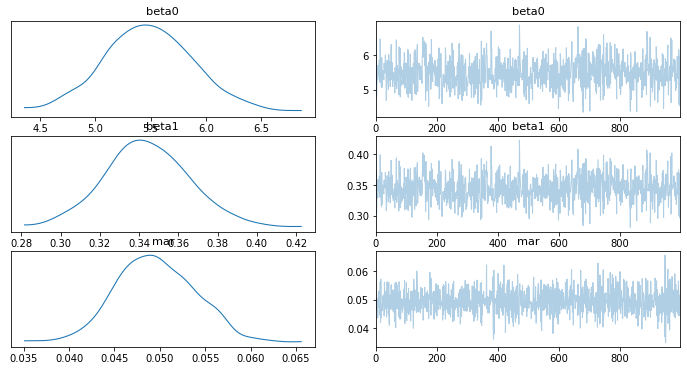

In [282]:
az.plot_trace(mcmc, var_names=["beta0", "beta1", "mar"])

array([[<AxesSubplot:title={'center':'mu_0'}>,
        <AxesSubplot:title={'center':'mu_0'}>],
       [<AxesSubplot:title={'center':'mu_1'}>,
        <AxesSubplot:title={'center':'mu_1'}>],
       [<AxesSubplot:title={'center':'mu_2'}>,
        <AxesSubplot:title={'center':'mu_2'}>],
       [<AxesSubplot:title={'center':'mu_3'}>,
        <AxesSubplot:title={'center':'mu_3'}>],
       [<AxesSubplot:title={'center':'mu_4'}>,
        <AxesSubplot:title={'center':'mu_4'}>],
       [<AxesSubplot:title={'center':'mu_5'}>,
        <AxesSubplot:title={'center':'mu_5'}>],
       [<AxesSubplot:title={'center':'mu_6'}>,
        <AxesSubplot:title={'center':'mu_6'}>],
       [<AxesSubplot:title={'center':'mu_7'}>,
        <AxesSubplot:title={'center':'mu_7'}>],
       [<AxesSubplot:title={'center':'mu_8'}>,
        <AxesSubplot:title={'center':'mu_8'}>],
       [<AxesSubplot:title={'center':'mu_9'}>,
        <AxesSubplot:title={'center':'mu_9'}>]], dtype=object)

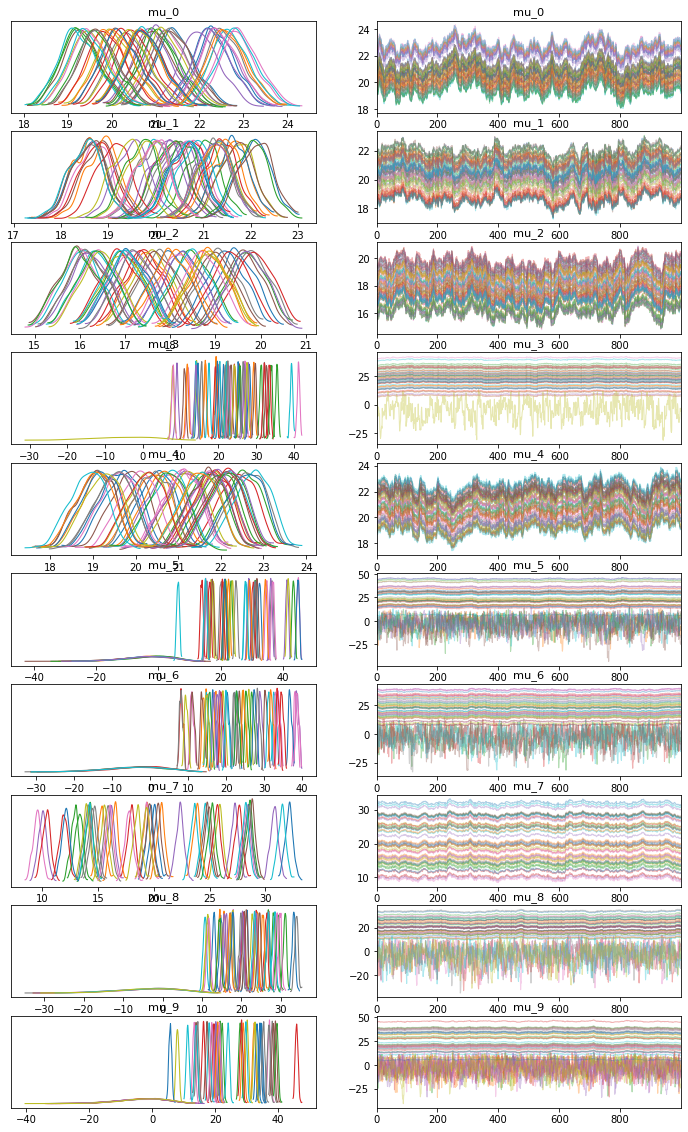

In [283]:
az.plot_trace(mcmc, var_names=["mu_{}".format(i) for i in range(10)])

/home/devonjkohler/.local/lib/python3.8/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (23), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'run_imp_1'}>,
        <AxesSubplot:title={'center':'run_imp_1'}>],
       [<AxesSubplot:title={'center':'run_imp_11'}>,
        <AxesSubplot:title={'center':'run_imp_11'}>],
       [<AxesSubplot:title={'center':'run_imp_12'}>,
        <AxesSubplot:title={'center':'run_imp_12'}>],
       [<AxesSubplot:title={'center':'run_imp_13'}>,
        <AxesSubplot:title={'center':'run_imp_13'}>],
       [<AxesSubplot:title={'center':'run_imp_15'}>,
        <AxesSubplot:title={'center':'run_imp_15'}>],
       [<AxesSubplot:title={'center':'run_imp_16'}>,
        <AxesSubplot:title={'center':'run_imp_16'}>],
       [<AxesSubplot:title={'center':'run_imp_17'}>,
        <AxesSubplot:title={'center':'run_imp_17'}>],
       [<AxesSubplot:title={'center':'run_imp_19'}>,
        <AxesSubplot:title={'center':'run_imp_19'}>],
       [<AxesSubplot:title={'center':'run_imp_2'}>,
        <AxesSubplot:title={'center':'run_imp_2'}>],
       [<AxesSubplot:title={'center':'run

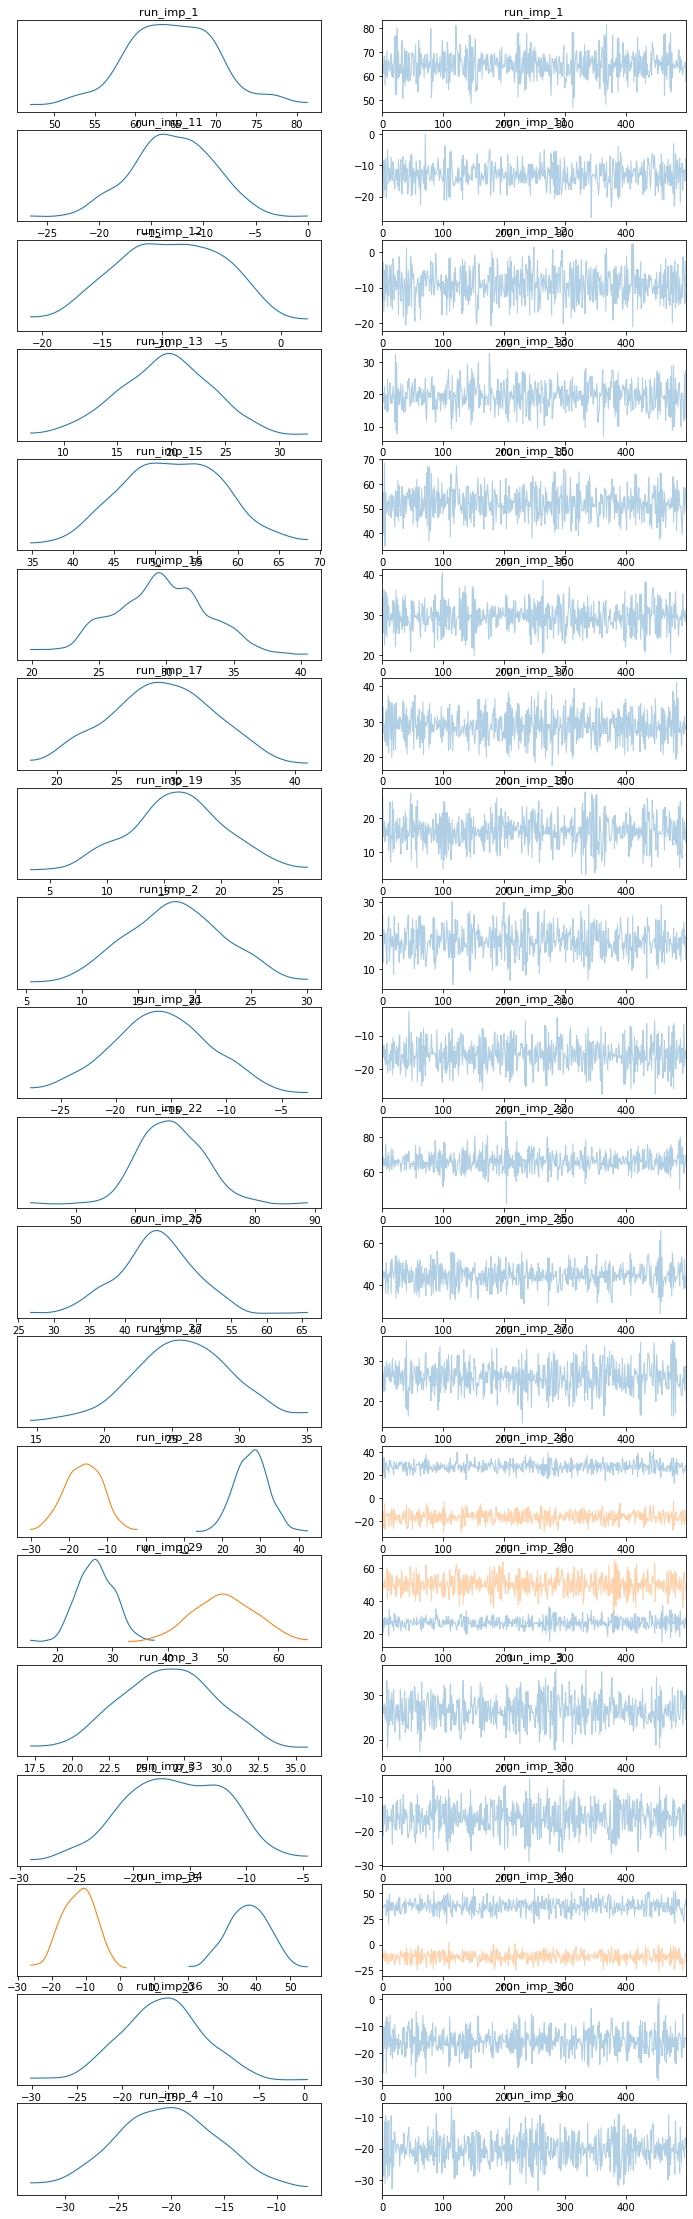

In [284]:
az.plot_trace(mcmc_run)

In [285]:
simulator.coef_list

{0: nan,
 1: nan,
 4: nan,
 2: nan,
 3: [tensor(-0.1084), tensor(-0.0379)],
 7: [tensor(0.2812)],
 6: [tensor(0.4367), tensor(-0.4558), tensor(0.0618)],
 8: [tensor(0.3051)],
 5: [tensor(0.0674), tensor(-0.0339), tensor(-0.2828)],
 9: [tensor(0.1908), tensor(0.1804), tensor(-0.2604)]}

## Individual imputed values

In [70]:
imp_results_list = list()
for i in range(len(simulator.data["Protein"].unique())):
    real_data = simulator.data[(simulator.data["Protein"] == i) & (np.isnan(simulator.data["Intensity"]))].reset_index(drop=True)
    tracker = list()
    idx=0
    for j in range(mcmc.posterior["imp_{}".format(i)].shape[2]):
        data = mcmc.posterior["imp_{}".format(i)][0][:,j]
        mean = data.mean()
        std = data.std()
        error = mean.values - real_data.loc[idx, "True_Intensity"]
        sqd_error = (mean.values - real_data.loc[idx, "True_Intensity"])**2
        tracker.append(pd.DataFrame({"Protein":[i], "Run" : [real_data.loc[idx, "Run"]], 
                                     "mean":[mean.values], "std":[std.values], "true_val" : [real_data.loc[idx, "True_Intensity"]], "error": [error],
                                    "sqd_error":[sqd_error]}))
        idx+=1
    imp_results_list.append(pd.concat(tracker))
        
imp_results = pd.concat(imp_results_list)


In [231]:
imp_results["sqd_error"].mean()

3.5653765587613973

In [224]:
imp_results["sqd_error"].mean()

3.6679751975374972

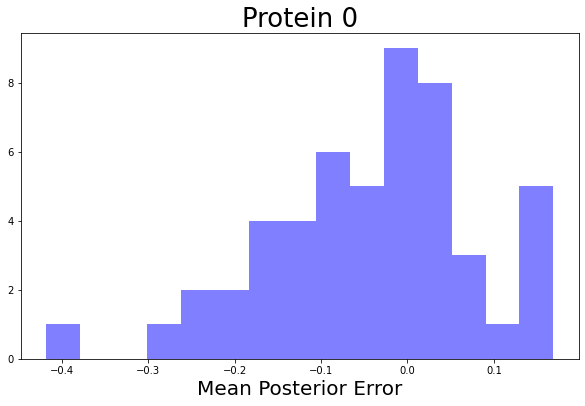

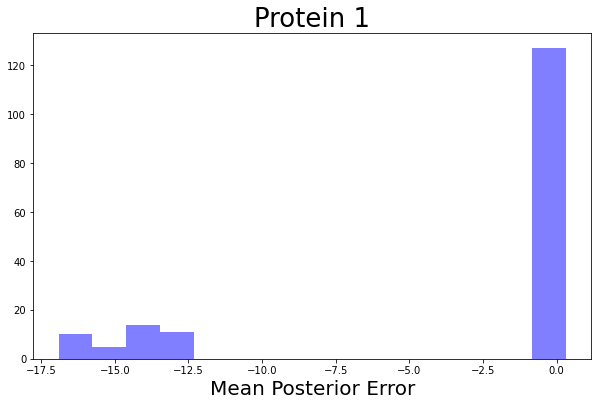

In [71]:
for i in range(len(simulator.data["Protein"].unique())):
    fig,ax = plt.subplots(figsize=(10,6))
    ax.hist(imp_results[imp_results["Protein"] == i]["error"], bins=15, color="blue", alpha=.5, label="normal")
    # ax.hist(imp_results["mcmc_lower"], bins=15, color="orange", alpha=.5, label="lower")
    ax.set_title("Protein {}".format(i), size=26)
    ax.set_xlabel("Mean Posterior Error", size=20)


In [73]:
simulator.data[(simulator.data["Protein"] == 1) & (simulator.data["Run"] == 0)]

Protein  Run  Feature  Run_effect  Protein_mean  Run_Protein_mean  \
250        1    0        0    1.463867      24.37152         15.746761   
251        1    0        1    1.463867      24.37152         15.746761   
252        1    0        2    1.463867      24.37152         15.746761   
253        1    0        3    1.463867      24.37152         15.746761   
254        1    0        4    1.463867      24.37152         15.746761   

     Feature_effect  True_std  Intensity  True_Intensity  MNAR_threshold  \
250        0.014805  0.111968        NaN       15.864058        0.538518   
251       -0.141546  0.111968        NaN       15.541891        0.570341   
252       -0.053084  0.111968        NaN       15.771405        0.547714   
253       -0.726313  0.111968  15.167491       15.167491        0.606591   
254        0.991962  0.111968  16.655917       16.655917        0.459497   

       MAR   MNAR  Missing  Impute  
250  False   True        1     1.0  
251  False   True        1     1.0  
252  False   True        1     1.0  
253  False  False        0     1.0  
254  False  False        0     1.0

In [348]:
mcmc.posterior["mu_5"][0][:, 10].mean()

<xarray.DataArray 'mu_5' ()>
array(5.992699, dtype=float32)
Coordinates:
    chain       int64 0
    mu_5_dim_0  int64 10

Text(0.5, 0, 'Mean Posterior Error')

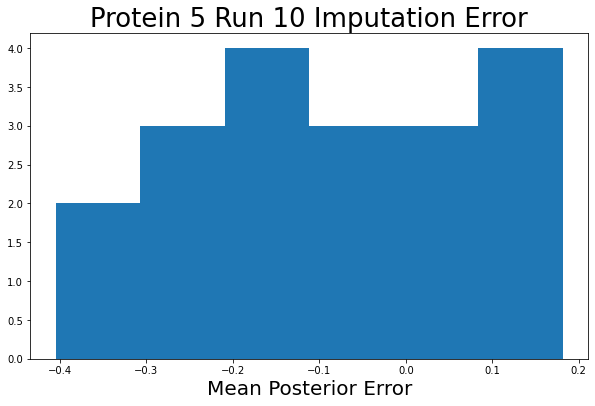

In [357]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(imp_results[(imp_results["Protein"] == 5) & (imp_results["Run"] == 10)]["error"], bins=6)
ax.set_title("Protein 5 Run 10 Imputation Error".format(i), size=26)
ax.set_xlabel("Mean Posterior Error", size=20)

/home/devonjkohler/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Mean Posterior Error')

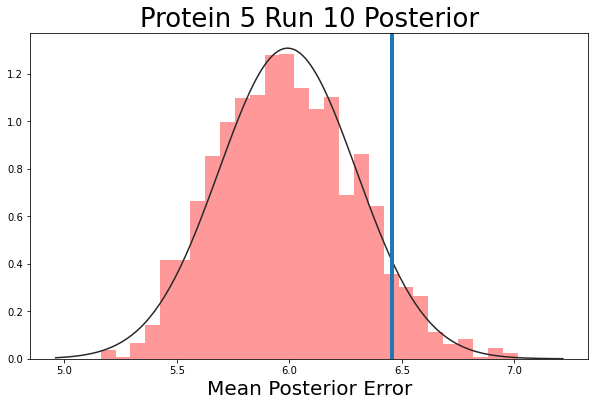

In [358]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(mcmc.posterior["mu_5"][0][:, 10], fit=scipy.stats.norm, kde=False, hist=True, color='r', ax=ax)
ax.axvline(6.455743	, lw = 4, label="True value")
ax.set_title("Protein 5 Run 10 Posterior".format(i), size=26)
ax.set_xlabel("Mean Posterior Error", size=20)

/home/devonjkohler/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/devonjkohler/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/devonjkohler/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

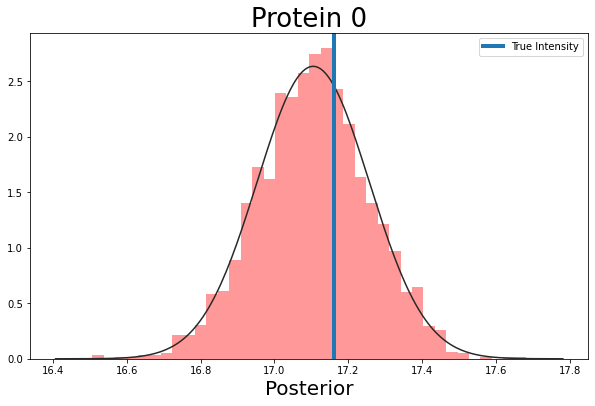

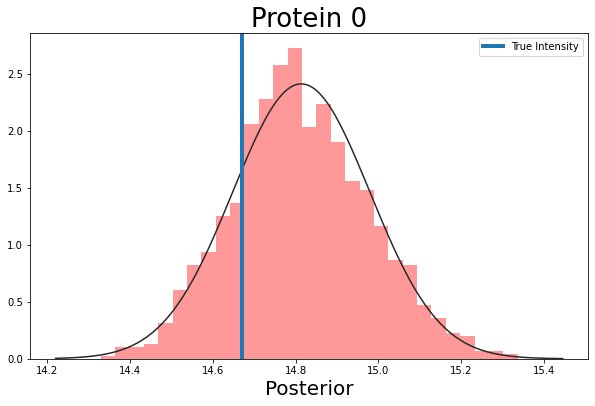

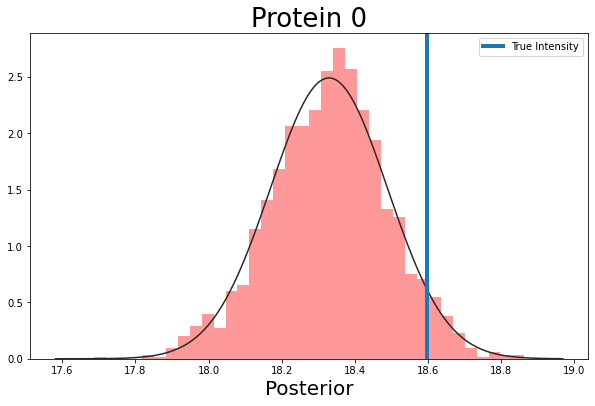

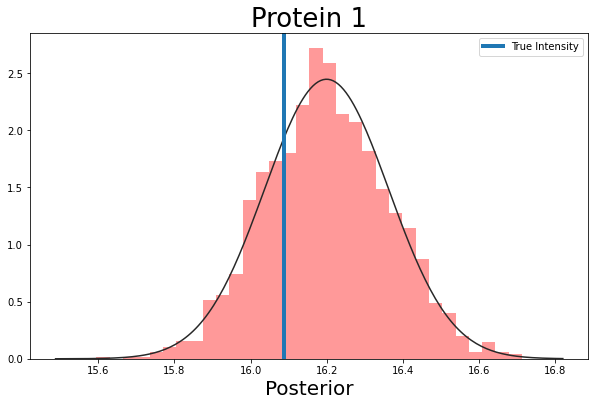

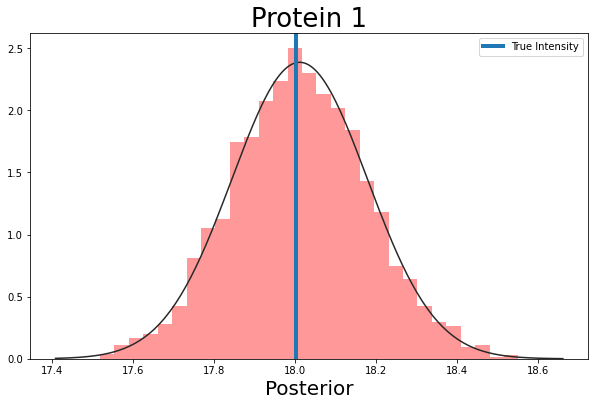

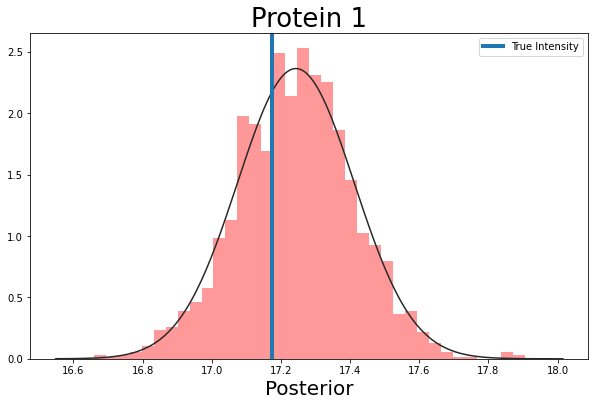

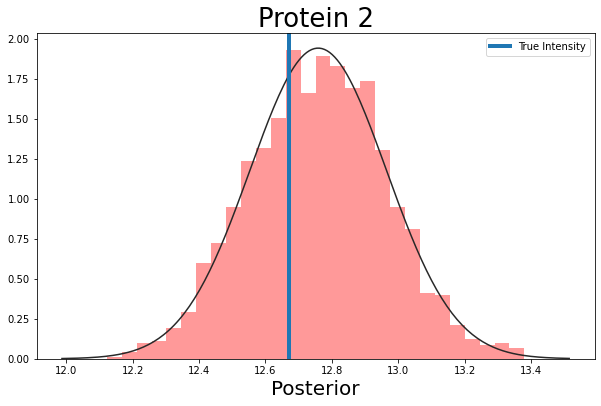

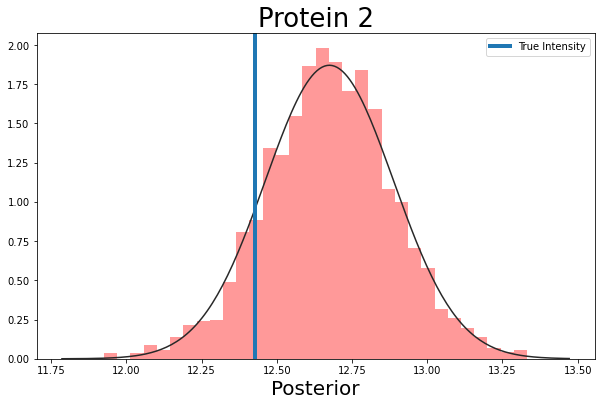

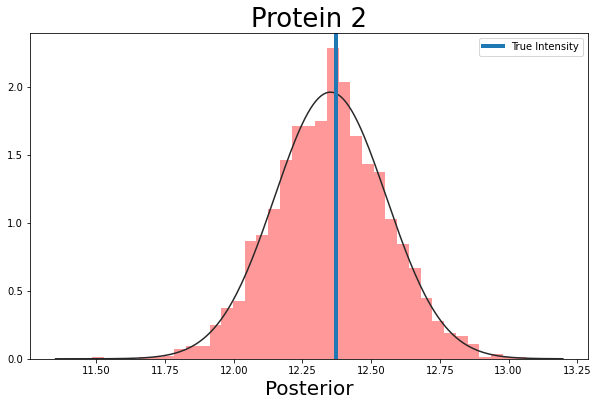

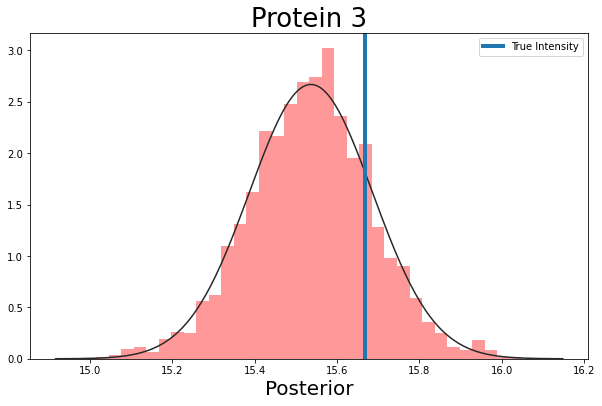

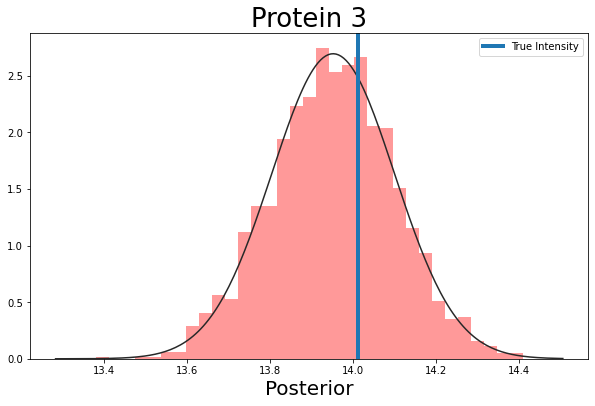

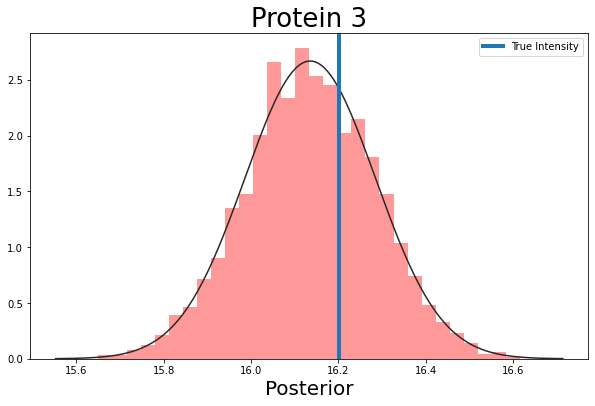

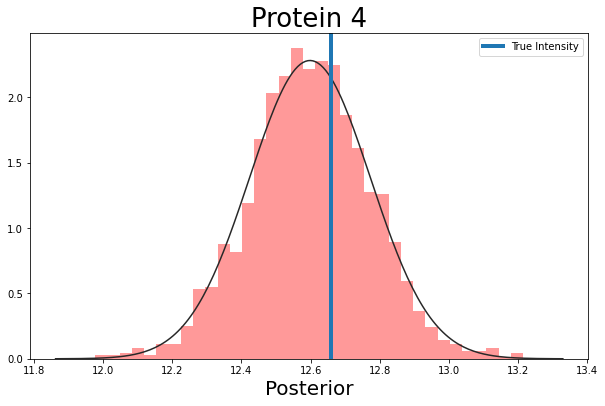

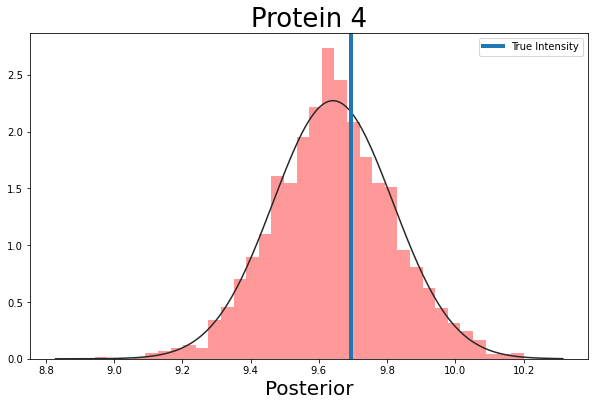

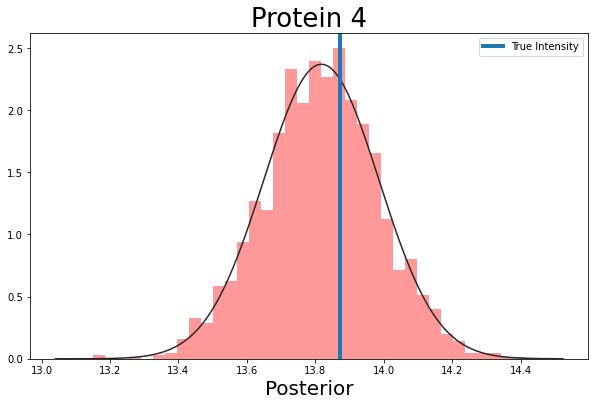

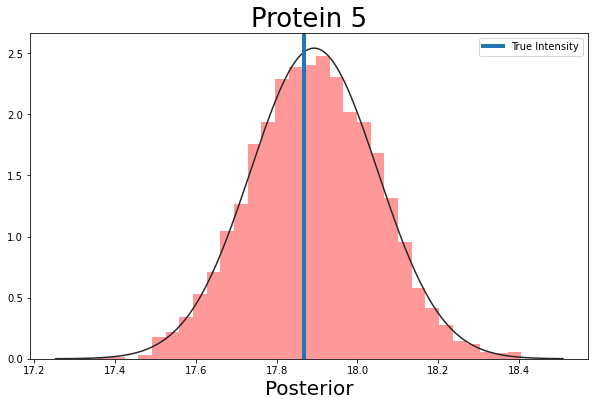

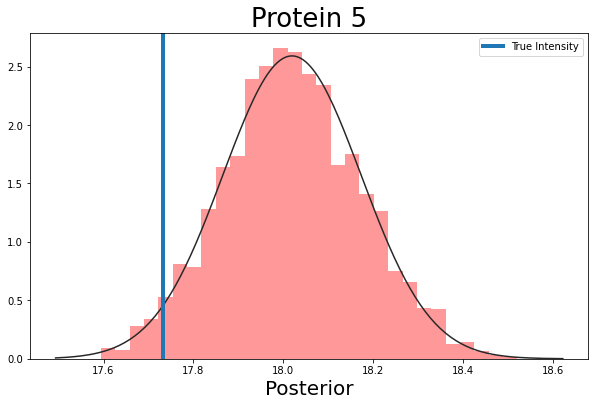

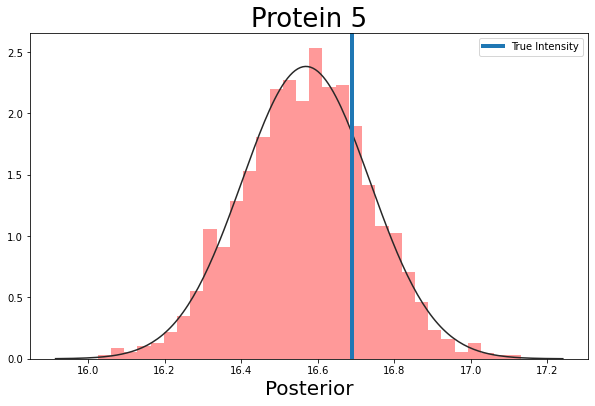

In [252]:
for i in range(len(simulator.data["Protein"].unique())):
    real_data = simulator.data[(simulator.data["Protein"] == i) & (np.isnan(simulator.data["Intensity"]))].reset_index(drop=True)
    tracker = list()
    idx=0
    for j in range(mcmc.posterior["imp_{}".format(i)].shape[2]):
        data = mcmc.posterior["imp_{}".format(i)][0][:,j]
        mean = data.mean()
        std = data.std()
        if idx < 3:
            fig, ax = plt.subplots(figsize=(10,6))
            sns.distplot(data, fit=scipy.stats.norm, kde=False, hist=True, color='r', ax=ax)
            ax.axvline(real_data.loc[idx, "True_Intensity"], lw = 4, label="True Intensity")
            ax.set_title("Protein {}".format(i), size=26)
            ax.set_xlabel("Posterior",size=20)
            plt.legend()
        idx+=1

In [276]:
imp_results[(-((imp_results["Protein"] == "2") & (imp_results["Run"] == 2))) & 
                       (-((imp_results["Protein"] == "3") & (imp_results["Run"].isin([4,7,13])))) &
                       (-((imp_results["Protein"] == "4") & (imp_results["Run"].isin([6,8,11]))))]

Protein  Run          mean                  std   true_val     error  \
0        0    0     17.104708  0.15133114159107208  17.160180 -0.055472   
0        0    0     14.813916  0.16542771458625793  14.670964  0.142952   
0        0    0     18.329092  0.16020406782627106  18.597273 -0.268181   
0        0    0     18.369532  0.15716978907585144  18.620773 -0.251241   
0        0    0     14.747105  0.16782060265541077  14.666531  0.080574   
0        0    0     16.288794  0.16534359753131866  16.201225  0.087568   
0        0    0      16.88007   0.1611238718032837  16.854808  0.025262   
0        0    0     17.099192  0.15738192200660706  17.477271 -0.378079   
0        0    0     16.072277  0.16278046369552612  16.395803 -0.323526   
0        0    1     13.831178  0.15708652138710022  13.982692 -0.151514   
0        0    1     14.332919   0.1560930609703064  14.427153 -0.094234   
0        0    1     14.171782  0.15232373774051666  14.267122 -0.095341   
0        0    1      11.62773   0.1704990416765213  11.705569 -0.077838   
0        0    1     12.120961  0.16356110572814941  12.268876 -0.147915   
0        0    1     13.952031  0.15714532136917114  14.289906 -0.337875   
0        0    1     13.776439  0.16796505451202393  14.036670 -0.260231   
0        0    1     13.512962  0.16611677408218384  13.608095 -0.095132   
0        0    1    13.9885025  0.15830257534980774  14.279703 -0.291201   
0        0    1     14.099904  0.16111651062965393  14.167870 -0.067966   
0        0    1     14.325252  0.16177035868167877  14.475610 -0.150358   
0        0    1     13.297129  0.16482004523277283  13.312884 -0.015755   
0        0    2     14.421525  0.16392584145069122  14.244476  0.177049   
0        0    2     12.213066    0.166917085647583  12.484656 -0.271590   
0        0    2     12.628343  0.17019134759902954  12.734167 -0.105824   
0        0    2     13.379576   0.1618524044752121  13.267437  0.112138   
0        0    2     14.068384   0.1540120393037796  14.366806 -0.298422   
0        0    2     14.536925  0.16378307342529297  14.327042  0.209884   
0        0    2     14.362199  0.17215898633003235  14.538869 -0.176671   
0        0    2    12.5579605   0.1726590096950531  12.163907  0.394053   
0        0    2     14.104254  0.16591998934745789  14.117469 -0.013215   
0        0    2      14.58031   0.1591031402349472  14.531489  0.048821   
0        0    2      13.76958  0.16127660870552063  13.832117 -0.062537   
0        0    2     14.688777  0.16409358382225037  14.773173 -0.084396   
0        0    2     14.910195  0.15730930864810944  14.869231  0.040965   
0        0    3     12.038699    0.169732928276062  12.074194 -0.035495   
0        0    3     12.456794   0.1652194708585739  12.138716  0.318078   
0        0    3      13.89772  0.15550120174884796  13.719798  0.177922   
0        0    3     15.966154  0.15645556151866913  16.039033 -0.072879   
0        0    3     14.365512  0.16475366055965424  14.251580  0.113932   
0        0    3     16.003061  0.15623393654823303  16.175563 -0.172502   
0        0    3     14.193238  0.16680505871772766  14.341930 -0.148692   
0        0    3     12.386246  0.17316868901252747  12.529403 -0.143157   
0        0    3      13.92386  0.16563427448272705  13.886980  0.036879   
0        0    3     14.402225  0.15704841911792755  14.745449 -0.343224   
0        0    3     13.600074   0.1621117889881134  13.593120  0.006954   
0        0    3     14.515504  0.16556094586849213  14.349239  0.166265   
0        0    3     14.733561   0.1553604006767273  14.888194 -0.154633   
0        0    4     17.573383  0.15820501744747162  17.321677  0.251707   
0        0    4     17.918194   0.1549454927444458  17.826505  0.091689   
0        0    4     15.365827  0.16211044788360596  15.274689  0.091138   
0        0    4    15.7793865  0.16288511455059052  15.424083  0.355304   
0        0    4     15.708621    0.167683407664299  15.544267  0.164354   
0        0    4     17.72892

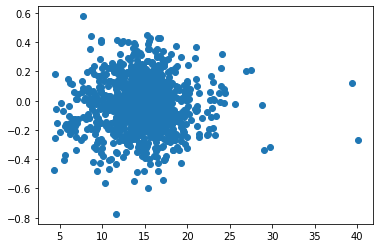

In [281]:
plot_data = imp_results[-((imp_results["Protein"] == 2) & (imp_results["Run"] == 2)) & 
                       -((imp_results["Protein"] == 3) & (imp_results["Run"].isin([4,7,13]))) &
                       -((imp_results["Protein"] == 4) & (imp_results["Run"].isin([6,8,11])))]
fig,ax = plt.subplots()
ax.scatter(plot_data["true_val"], plot_data["error"])

## Run level comparison

In [135]:
mcmc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [319]:
real_data = simulator.data[(simulator.data["Protein"] == 0)].reset_index(drop=True)

imp_results_list = list()
idx=0
for i in range(len(simulator.data["Protein"].unique())):
    real_data = simulator.data[(simulator.data["Protein"] == i) & (np.isnan(simulator.data["Intensity"]))].reset_index(drop=True)
    for r in range(len(simulator.data["Run"].unique())):
        run_gt = real_data.loc[real_data["Run"] == r]["Run_Protein_mean"].unique()
        
        data = mcmc.posterior["mu_{}".format(i)][0][:,r]
        mean = data.mean()
        std = data.std()
        
        error = mean.values - run_gt
        imp_results_list.append(pd.DataFrame({"Protein": i, "Run": r, 
                                              "mean": mean.values, "std": std.values,
                                              "error": error}))
        idx+=1

imp_results = pd.concat(imp_results_list)

In [137]:
imp_results

Protein  Run       mean       std     error
0        0    0  16.602520  0.221857 -0.167557
0        0    1  13.821983  0.220053 -0.256567
0        0    2  14.410727  0.227429 -0.072480
0        0    3  14.236510  0.225606 -0.116789
0        0    4  17.562801  0.222202 -0.052904
0        0    5  16.497261  0.231362 -0.244194
0        0    6  16.147104  0.224900 -0.092297
0        0    7  16.466602  0.220588 -0.094969
0        0    8  14.176262  0.228201  0.029911
0        0    9  15.903419  0.223408  0.043900
0        0   10  13.664861  0.242479 -0.137004
0        0   11  14.941860  0.223115 -0.082721
0        0   12  17.307838  0.222241 -0.111292
0        0   13  16.473003  0.228360 -0.045532
0        0   14  14.078701  0.227969 -0.110953
0        0   15  15.112309  0.224633 -0.116923
0        0   16  16.207426  0.231724 -0.128624
0        0   17  17.530033  0.223686 -0.075456
0        0   18  14.483417  0.233414 -0.090333
0        0   19  17.015160  0.225994 -0.113903
0        1    0  18.070469  0.223384  0.394291
0        1    1  15.382419  0.232495  0.397767
0        1    2  15.799069  0.231980  0.409761
0        1    3  15.697751  0.223207  0.438350
0        1    4  18.899889  0.224546  0.378082
0        1    5  18.129963  0.226601  0.482406
0        1    6  17.556305  0.225417  0.410802
0        1    7  17.796299  0.225263  0.328626
0        1    8  15.444183  0.225333  0.391730
0        1    9  17.147041  0.226326  0.381421
0        1   10  15.027106  0.221825  0.319140
0        1   11  16.350002  0.227779  0.419319
0        1   12  18.691793  0.227389  0.366561
0        1   13  17.846888  0.225286  0.422250
0        1   14  15.395248  0.226233  0.299493
0        1   15  16.489403  0.221624  0.354070
0        1   16  17.604223  0.223335  0.362071
0        1   17  18.928558  0.224251  0.416967
0        1   18  15.890362  0.228042  0.410511
0        1   19  18.338800  0.227923  0.303636
0        2    1  12.917648  0.277921  0.069195
0        2    2   0.910250  6.326464 -8.955681
0        2    3   9.307682  0.258673  0.000067
0        2    4  15.057450  0.228937 -0.001472
0        2    5   9.174311  0.261199  0.263051
0        2    6  15.782591  0.231411 -0.164749
0        2    7  24.514324  0.224974 -0.018397
0        2    8  12.891711  0.236741  0.157586
0        2    9  17.145922  0.228424  0.011481
0        2   10   9.805942  0.273526 -0.310904
0        2   11  19.777462  0.226370 -0.050979
0        2   12  12.581169  0.246683 -0.151583
0        2   13  15.237789  0.226370 -0.070115
0        2   14  14.997200  0.233497  0.066606
0        2   15  11.674441  0.241819 -0.021040
0        2   17  23.042532  0.223941 -0.080152
0        2   18  12.679483  0.236660 -0.144761
0        2   19  23.322168  0.226316  0.039777
0        3    0  15.363642  0.246163  0.084259
0        3    1  18.102530  0.244490  0.204577
0        3    2  16.289398  0.247650  0.201160
0        3    3  17.466120  0.245283  0.206091
0        3    4   2.579295  5.168700 -6.329495
0        3    5  23.653820  0.243492  0.194895
0        3    6  15.250499  0.248378  0.202164
0        3    7   1.375824  5.454812 -0.949213
0        3    8  19.049442  0.244833  0.160966
0        3    9  21.951279  0.246038  0.147511
0        3   10  21.916277  0.243479  0.214297
0        3   12  29.448484  0.243941  0.217408
0        3   13   1.819263  5.995243 -4.039695
0        3   14  21.120512  0.245217  0.188445
0        3   15  17.537516  0.243149  0.173404
0        3   16  20.447214  0.244054  0.214346
0        3   18  17.098932  0.245405  0.220606
0        3   19  16.107143  0.245493  0.201770
0        4    0  11.767198  0.246805 -0.528324
0        4    1  14.731757  0.234550 -0.543106
0        4    2   5.961478  0.257727 -0.641438
0        4    3  10.733323  0.244653 -0.533853
0        4    4  16.896355  0.232527 -0.515477
0        4    5  15.659941  0.233934 -0.613481
0        4    6   0.889190  6.385297 -6.199525
0        4    7  17.478313  0.232811 -0.535466
0       

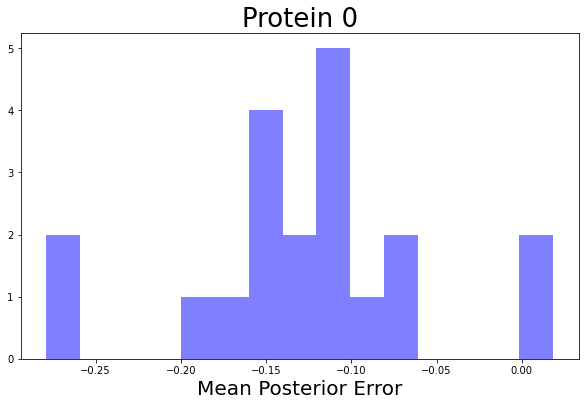

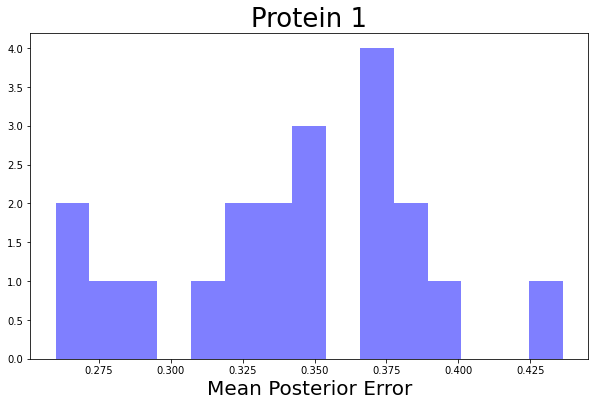

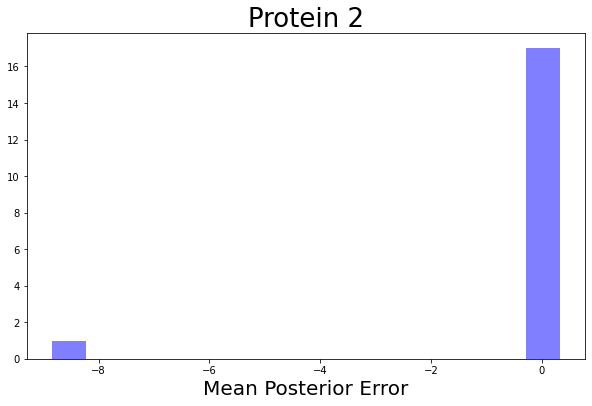

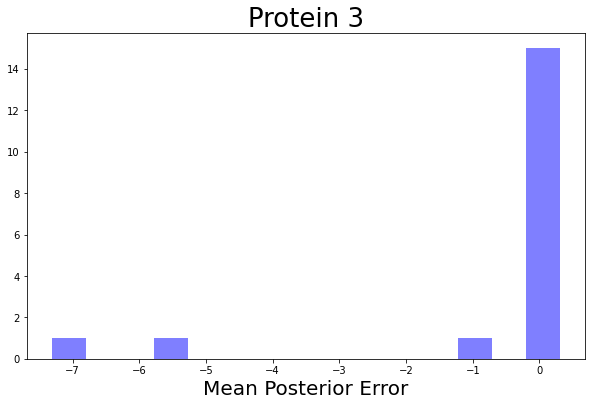

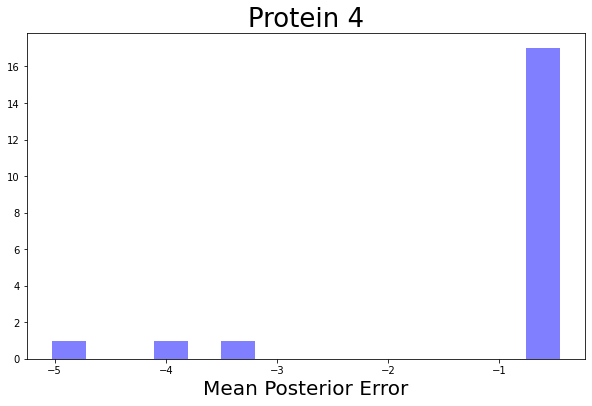

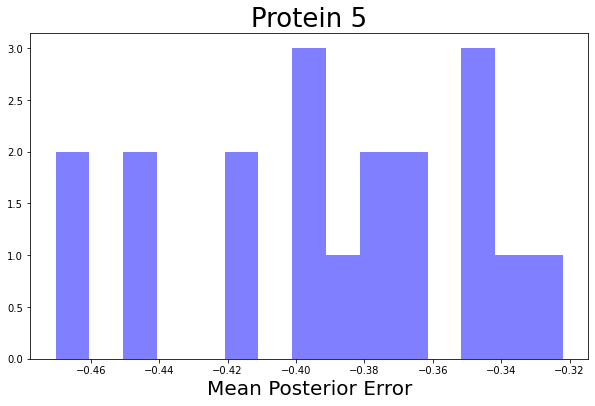

In [320]:
for i in range(len(simulator.data["Protein"].unique())):
    fig,ax = plt.subplots(figsize=(10,6))
    ax.hist(imp_results[imp_results["Protein"] == i]["error"], bins=15, color="blue", alpha=.5, label="normal")
    # ax.hist(imp_results["mcmc_lower"], bins=15, color="orange", alpha=.5, label="lower")
    ax.set_title("Protein {}".format(i), size=26)
    ax.set_xlabel("Mean Posterior Error", size=20)


## Feature level comparison

In [142]:
mcmc.posterior["bF_0"].shape

(1, 1000, 20)

In [321]:
imp_results_list = list()
idx=0
for i in range(len(simulator.data["Protein"].unique())):
    real_data = simulator.data[(simulator.data["Protein"] == i) & (np.isnan(simulator.data["Intensity"]))].reset_index(drop=True)
    for f in range(len(simulator.data["Feature"].unique())):
        run_gt = real_data.loc[real_data["Feature"] == f]["Feature_effect"].unique()
        
        data = mcmc.posterior["bF_{}".format(i)][0][:,f]
        mean = data.mean()
        std = data.std()
        
        error = mean.values - run_gt
        imp_results_list.append(pd.DataFrame({"Protein": i, "Feature": f, 
                                              "mean": mean.values, "std": std.values,
                                              "error": error}))
        idx+=1

imp_results = pd.concat(imp_results_list)

In [144]:
imp_results

Protein  Feature      mean       std     error
0        0        0  0.039769  0.225464  0.178775
0        0        1  0.538732  0.224423  0.040487
0        0        2 -0.182188  0.220795  0.098432
0        0        3  0.381633  0.224624  0.039197
0        0        4 -2.161482  0.234620  0.086187
0        0        5 -1.741934  0.233232  0.237690
0        0        6 -0.998420  0.224298  0.169493
0        0        7 -1.669932  0.224550  0.067862
0        0        8 -0.313237  0.220779  0.029990
0        0        9  1.753392  0.221405  0.037931
0        0       10  0.154135  0.230957  0.135370
0        0       11  1.792976  0.221116  0.120017
0        0       12 -0.018383  0.226963  0.189992
0        0       13 -1.817693  0.234796  0.227185
0        0       14 -0.277816  0.231577  0.069613
0        0       15  0.195709  0.223682  0.102990
0        0       16 -0.607256  0.221670  0.076267
0        0       17  0.309064  0.227549  0.114498
0        0       18  0.527598  0.223445  0.025725
0        0       19 -0.495368  0.227633  0.174105
0        1        0 -1.837730  0.224399 -0.339280
0        1        1 -0.033665  0.223077 -0.430635
0        1        2 -1.227911  0.226183 -0.380385
0        1        3  0.914370  0.224464 -0.440849
0        1        4 -0.167564  0.223239 -0.391358
0        1        5  1.746981  0.223404 -0.331007
0        1        6 -0.795074  0.227611 -0.291320
0        1        7 -0.346446  0.234565 -0.527402
0        1        8  0.787996  0.224513 -0.437005
0        1        9  0.045644  0.226619 -0.365065
0        1       10  0.161548  0.226929 -0.341763
0        1       11 -0.792752  0.227376 -0.314293
0        1       12  0.704459  0.226348 -0.307302
0        1       13 -0.577812  0.227432 -0.348839
0        1       14 -0.383054  0.225223 -0.460589
0        1       15 -0.750039  0.226799 -0.433236
0        1       16 -0.619474  0.223867 -0.365798
0        1       17 -0.232077  0.225849 -0.483530
0        1       18  1.216598  0.221729 -0.343152
0        1       19 -2.006579  0.239939 -0.401499
0        2        0 -0.131669  0.226677  0.060008
0        2        1 -0.215394  0.236217  0.042978
0        2        2 -0.537903  0.232309 -0.072832
0        2        3 -0.879373  0.228989  0.029750
0        2        4  1.091098  0.227433  0.041214
0        2        5  1.460007  0.226270  0.041885
0        2        6  0.461227  0.232877  0.070384
0        2        7  0.016303  0.230771 -0.003266
0        2        8  0.590587  0.228254 -0.012609
0        2        9  0.002159  0.230007  0.028925
0        2       10  1.075259  0.227235  0.014649
0        2       11  0.721219  0.229351  0.092326
0        2       12 -0.225600  0.232834  0.049852
0        2       13  0.923066  0.227776  0.037850
0        2       14 -0.697335  0.227024  0.134902
0        2       15 -0.835103  0.225187  0.033121
0        2       16 -1.297587  0.235805 -0.072995
0        2       17  1.058266  0.227809 -0.098621
0        2       18  1.601451  0.226973  0.058759
0        2       19  0.012408  0.231155  0.058498
0        3        0  1.898228  0.246298 -0.074796
0        3        1  0.203371  0.245860 -0.166973
0        3        2  2.018568  0.243071 -0.155755
0        3        3 -1.386473  0.245620 -0.182685
0        3        4  0.800781  0.242778 -0.264337
0        3        5  0.369087  0.243636 -0.210595
0        3        6  0.801152  0.245551 -0.218708
0        3        7 -0.201630  0.247197 -0.172711
0        3        8 -1.000083  0.244160 -0.211004
0        3        9 -0.057651  0.243088 -0.151323
0        3       10  0.010610  0.245157 -0.228350
0        3       11  0.775517  0.242947 -0.214912
0        3       12  0.840951  0.245317 -0.220266
0        3       13 -0.922414  0.244888 -0.213135
0        3       14 -0.238128  0.245833 -0.164013
0        3       15 -1.004475  0.245123 -0.225060
0        3       16 -0.743194  0.247106 -0.213366
0        3       17  0.382081  0.245135 -0.180206
0        3       18 -0.325913  0.245346 -0.177218
0  

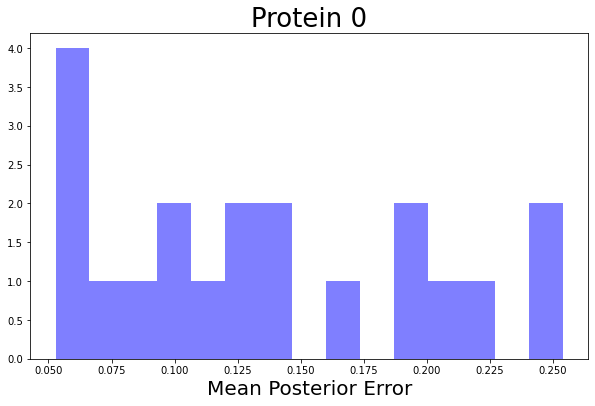

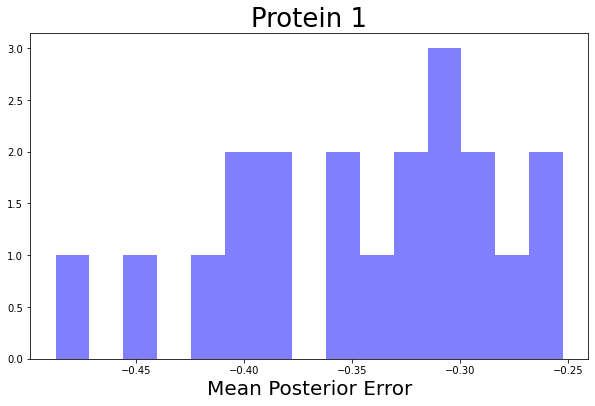

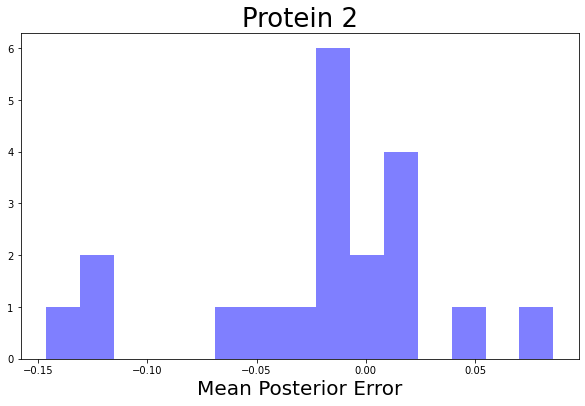

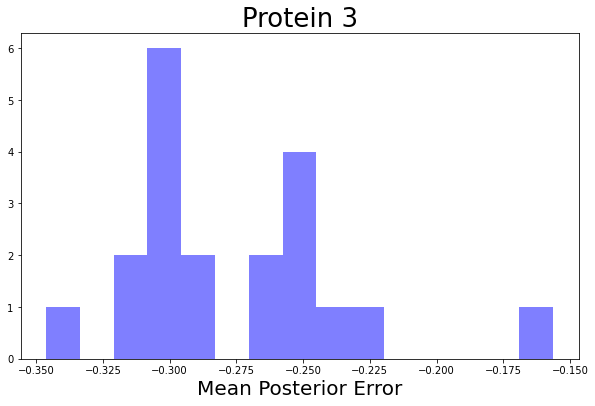

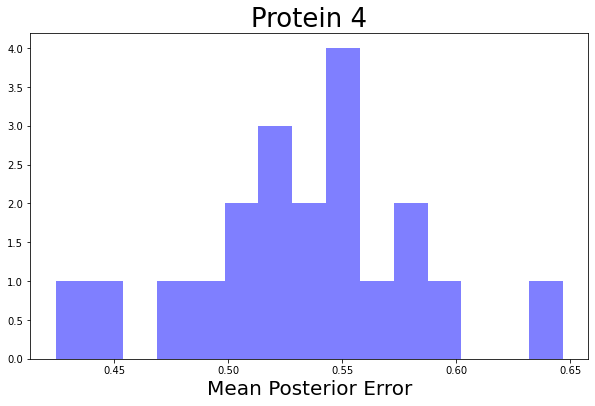

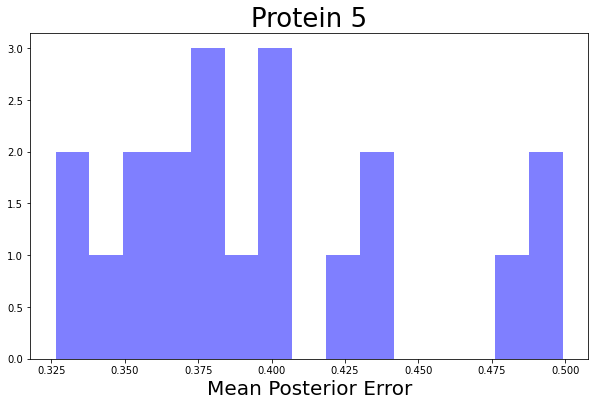

In [322]:
for i in range(len(simulator.data["Protein"].unique())):
    fig,ax = plt.subplots(figsize=(10,6))
    ax.hist(imp_results[imp_results["Protein"] == i]["error"], bins=15, color="blue", alpha=.5, label="normal")
    # ax.hist(imp_results["mcmc_lower"], bins=15, color="orange", alpha=.5, label="lower")
    ax.set_title("Protein {}".format(i), size=26)
    ax.set_xlabel("Mean Posterior Error", size=20)


In [253]:
mcmc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Analyze sim

In [732]:
with open(r"../model_code/data/simulated_data_two.pickle", "rb") as input_file:
    simulator = pickle.load(input_file)

In [603]:
simulator.network.edges

OutEdgeView([(0, 2), (1, 2)])

In [635]:
simulator.data[simulator.data["Protein"] == 1].head()

Protein  Run  Feature  Run_effect  Protein_mean  Run_Protein_mean  \
200        1    0        0   -0.043822     18.131357         25.670755   
201        1    0        1   -0.043822     18.131357         25.670755   
202        1    0        2   -0.043822     18.131357         25.670755   
203        1    0        3   -0.043822     18.131357         25.670755   
204        1    0        4   -0.043822     18.131357         25.670755   

     Feature_effect  True_std  Intensity  True_Intensity  MNAR_threshold  \
200       -0.002587  0.235487  25.562107       25.562107        0.023549   
201       -0.167228  0.235487  25.204078       25.204078        0.027077   
202        0.190891  0.235487  25.650852       25.650852        0.022746   
203       -0.669743  0.235487        NaN       25.006797        0.029235   
204        1.116228  0.235487  26.970426       26.970426        0.013544   

       MAR   MNAR  Missing  Impute  
200  False  False        0       1  
201  False  False        0       1  
202  False  False        0       1  
203  False   True        1       1  
204  False  False        0       1

In [484]:
simulator.data[simulator.data["Run"] == 13]

Protein  Run  Feature  Run_effect  Protein_mean  Run_Protein_mean  \
1300        0   13        0     9.11776     16.066015         25.183775   
1301        0   13        1     9.11776     16.066015         25.183775   
1302        0   13        2     9.11776     16.066015         25.183775   
1303        0   13        3     9.11776     16.066015         25.183775   
1304        0   13        4     9.11776     16.066015         25.183775   
1305        0   13        5     9.11776     16.066015         25.183775   
1306        0   13        6     9.11776     16.066015         25.183775   
1307        0   13        7     9.11776     16.066015         25.183775   
1308        0   13        8     9.11776     16.066015         25.183775   
1309        0   13        9     9.11776     16.066015         25.183775   
1310        0   13       10     9.11776     16.066015         25.183775   
1311        0   13       11     9.11776     16.066015         25.183775   
1312        0   13       12     9.11776     16.066015         25.183775   
1313        0   13       13     9.11776     16.066015         25.183775   
1314        0   13       14     9.11776     16.066015         25.183775   
1315        0   13       15     9.11776     16.066015         25.183775   
1316        0   13       16     9.11776     16.066015         25.183775   
1317        0   13       17     9.11776     16.066015         25.183775   
1318        0   13       18     9.11776     16.066015         25.183775   
1319        0   13       19     9.11776     16.066015         25.183775   
1320        0   13       20     9.11776     16.066015         25.183775   
1321        0   13       21     9.11776     16.066015         25.183775   
1322        0   13       22     9.11776     16.066015         25.183775   
1323        0   13       23     9.11776     16.066015         25.183775   
1324        0   13       24     9.11776     16.066015         25.183775   
1325        0   13       25     9.11776     16.066015         25.183775   
1326        0   13       26     9.11776     16.066015         25.183775   
1327        0   13       27     9.11776     16.066015         25.183775   
1328        0   13       28     9.11776     16.066015         25.183775   
1329        0   13       29     9.11776     16.066015         25.183775   
1330        0   13       30     9.11776     16.066015         25.183775   
1331        0   13       31     9.11776     16.066015         25.183775   
1332        0   13       32     9.11776     16.066015         25.183775   
1333        0   13       33     9.11776     16.066015         25.183775   
1334        0   13       34     9.11776     16.066015         25.183775   
1335        0   13       35     9.11776     16.066015         25.183775   
1336        0   13       36     9.11776     16.066015         25.183775   
1337        0   13       37     9.11776     16.066015         25.183775   
1338        0   13       38     9.11776     16.066015         25.183775   
1339        0   13       39     9.11776     16.066015         25.183775   
1340        0   13       40     9.11776     16.066015         25.183775   
1341        0   13       41     9.11776     16.066015         25.183775   
1342        0   13       42     9.11776     16.066015         25.183775   
1343        0   13       43     9.11776     16.066015         25.183775   
1344        0   13       44     9.11776     16.066015         25.183775   
1345        0   13       45     9.11776     16.066015         25.183775   
1346        0   13       46     9.11776     16.066015         25.183775   
1347        0   13       47     9.11776     16.066015         25.183775   
1348        0   13       48     9.11776     16.066015         25.183775   
1349        0   13       49     9.11776     16.066015         25.183775   
1350        0   13       50     9.11776     16.066015         25.183775   
1351        0   13       51     9.11776     16.066015         25.183775   
1352        0   13       52    

In [649]:
simulator.coef_list

{0: nan, 1: [tensor(0.5000)]}

In [474]:
simulator.data[simulator.data["Protein"] == 1]["True_Intensity"].mean()

11.456387219471988

In [538]:
plot_data[plot_data["Feature"] == "7"]["Feature_effect"].unique()

array([-1.53321325,  1.87731485])

Text(0, 0.5, 'Protein 2')

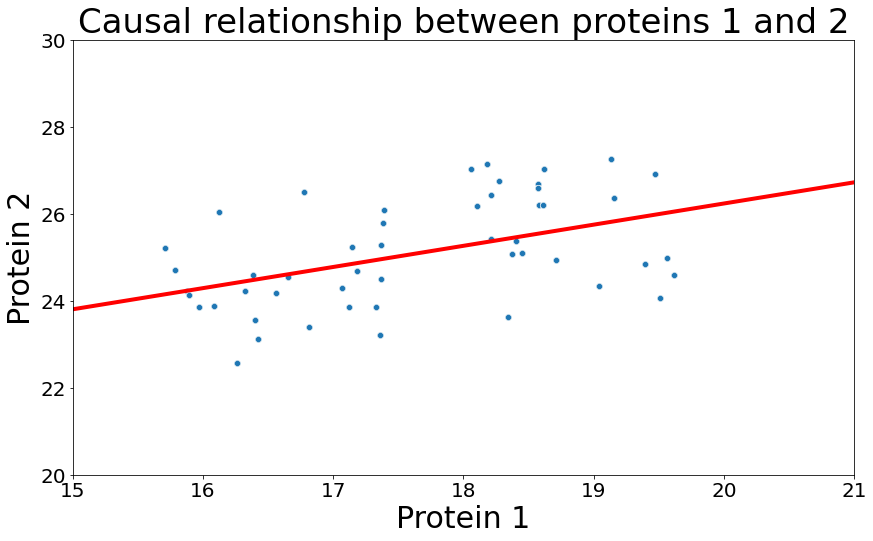

In [756]:
plot_data = simulator.data
plot_data.loc[:, "Feature"] = plot_data.loc[:, "Feature"].astype(str)
fig, ax = plt.subplots(figsize=(14,8))
sns.scatterplot(x=plot_data[(plot_data["Protein"] == 0)]["Run_Protein_mean"].values, 
                y=plot_data[(plot_data["Protein"] == 1)]["Run_Protein_mean"].values, ax=ax)
ax.axline((0, 16.51), slope=.48641074, color="red", lw=4)
ax.set_xlim(15,21)
ax.set_ylim(20,30)

ax.set_title("Causal relationship between proteins 1 and 2",fontdict={'fontsize': 34})
ax.set_xlabel("Protein 1",fontdict={'fontsize': 30})
ax.set_ylabel("Protein 2",fontdict={'fontsize': 30})

In [578]:
18.155824 + 10*.11

19.255824

In [735]:
from sklearn.linear_model import LinearRegression

model_data = simulator.data
X = simulator.data[simulator.data["Protein"] == 0][["Run_Protein_mean", "Run"]]
X.loc[:, "Run"] = X.loc[:, "Run"].astype(str)
# X.loc[:, "Feature"] = X.loc[:, "Feature"].astype(str)
X = pd.get_dummies(X)
y = simulator.data[simulator.data["Protein"] == 1]["Run_Protein_mean"]

model = LinearRegression()
model.fit(X, y)
print(model.intercept_)
print(model.coef_)


16.516546536915918
[ 0.48641074  1.12999077  1.81375649 -0.3682619   0.11733154 -0.38315522
 -0.00456482  0.82732614 -0.09140571 -0.98640623 -0.93253879  1.04898796
  1.78111873 -1.47033924 -0.22834772 -0.51011475  0.65857207  0.85218733
  0.32883979 -1.04312177  1.44854824  1.34866547  1.67667158  0.50588704
 -0.43205724 -0.1111261   0.53134397  0.38770793 -0.19723382 -0.38751299
 -0.06046202  0.04112341  1.4366955  -1.07485991 -1.38288843  1.04120352
 -1.85593734 -1.0998169   0.6439258  -1.75077264 -1.93937584  1.74214711
  1.11452951 -1.44790413 -0.68465249 -0.46817592 -1.81660102  0.93475426
 -1.28986498 -0.45024158  1.05642532]


/tmp/ipykernel_26040/800202362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_26040/800202362.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_26040/800202362.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

Text(0.5, 0, 'Run')

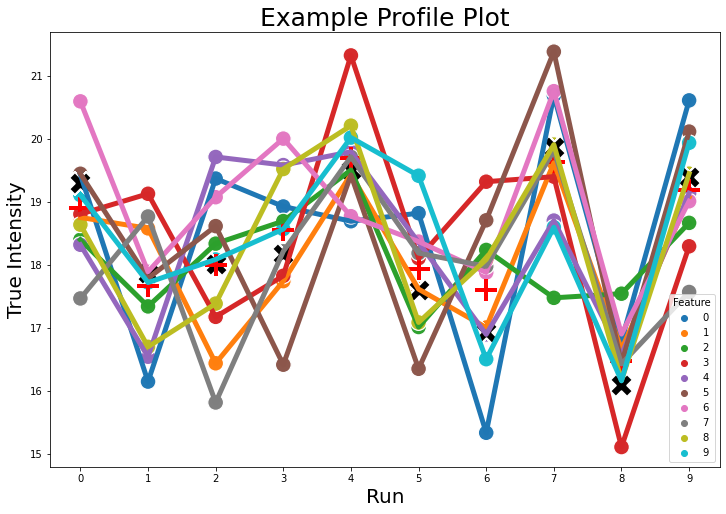

In [69]:
profile = simulator.data[simulator.data["Protein"] == 0.]
profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Run"] = profile.loc[:, "Run"].astype(str)
profile.loc[:, "Run_mean"] = profile.loc[:, "Protein_mean"] + profile.loc[:, "Run_effect"]
infer = profile.groupby("Run")["True_Intensity"].mean().reset_index()
infer = infer.rename(columns={"True_Intensity" : "infer_mean"})
profile = pd.merge(profile, infer, how="left", on="Run")

fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(data=profile, x="Run", y="True_Intensity", hue="Feature",ax=ax,lw=5, legend=False)
sns.scatterplot(data=profile, x="Run", y="True_Intensity", hue="Feature",ax=ax, s=250, alpha=.99)

sns.scatterplot(data=profile, x="Run", y="Run_mean",ax=ax, s=500, marker="X", legend=False, color="black")
sns.scatterplot(data=profile, x="Run", y="Run_mean",ax=ax, s=500, marker="X", legend=False, color="black")
sns.scatterplot(data=profile, x="Run", y="infer_mean",ax=ax, s=500, marker="+", legend=False, color="red",linewidth=3.5)


ax.set_title("Example Profile Plot",fontdict={'fontsize': 25})
ax.set_ylabel("True Intensity",fontdict={'fontsize': 20})
ax.set_xlabel("Run",fontdict={'fontsize': 20})

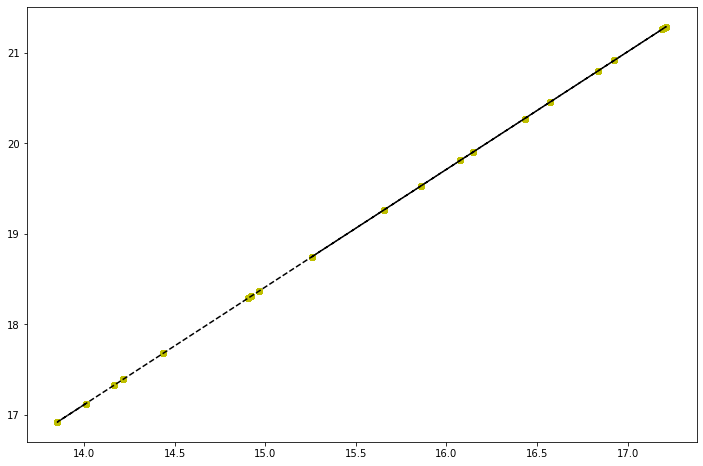

In [17]:
fig, ax = plt.subplots(figsize=(12,8))

protein0 = simulator.data[simulator.data["Protein"] == 0]
protein1 = simulator.data[simulator.data["Protein"] == 1]

coef = np.polyfit(protein0["Intensity"],protein1["Intensity"],1)
poly1d_fn = np.poly1d(coef) 

ax.plot(protein0["Intensity"], protein1["Intensity"], 'yo', protein0["Intensity"], poly1d_fn(protein0["Intensity"]), '--k')

In [18]:
coef

array([ 1.3       , -1.08779046])

Text(0.5, 0, 'Log2 Feature intensity')

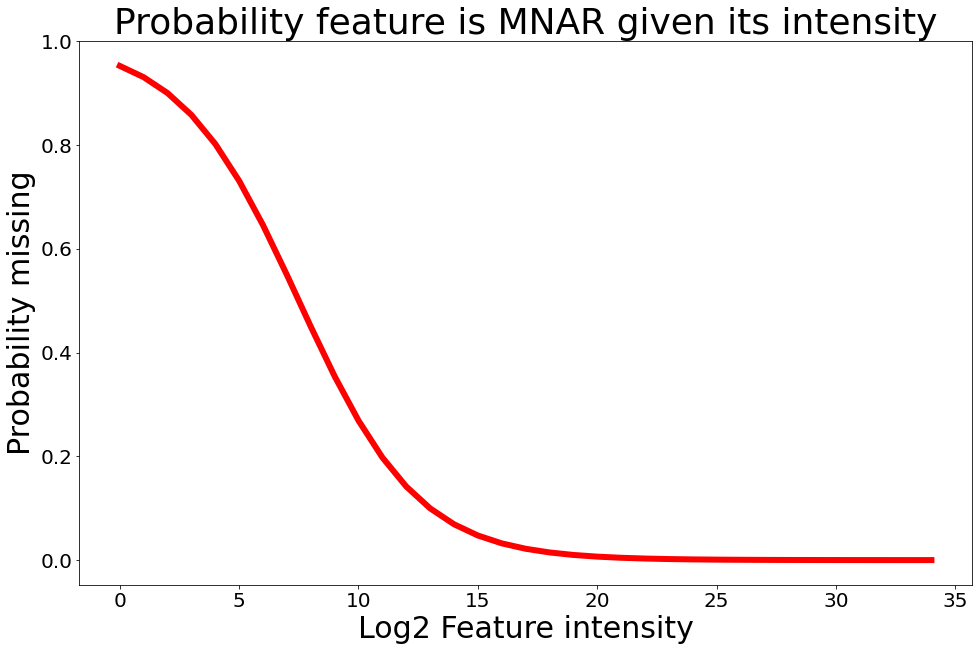

In [7]:

fig, ax = plt.subplots(figsize=(16,10))
# ax.scatter(x=mnar["True_Intensity"], y=mnar["Missing_count"]/5)
# ax.plot(np.arange(7,27), [(1 / (1 + np.exp(-6.5 + (.42 * i)))) for i in np.arange(7,27)], color="orange", lw=4)
ax.plot(np.arange(0,35), [1 / (1 + np.exp(-3 + (.4 * i))) for i in np.arange(0,35)], color="red", lw=6)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
ax.set_title("Probability feature is MNAR given its intensity",fontdict={'fontsize': 36})
ax.set_ylabel("Probability missing",fontdict={'fontsize': 30})
ax.set_xlabel("Log2 Feature intensity",fontdict={'fontsize': 30})

(0.0, 1.0)

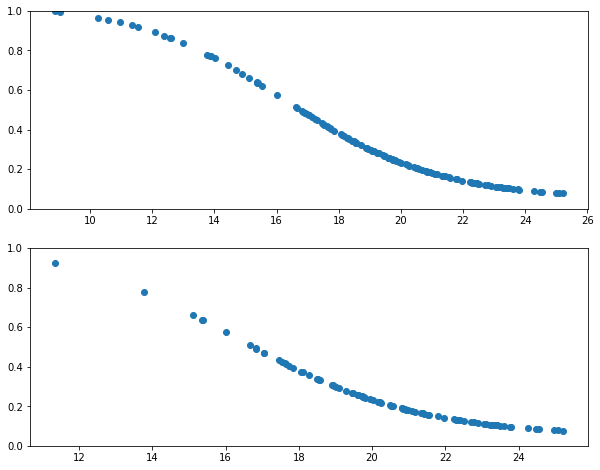

In [62]:
fig, ax = plt.subplots(2,1,figsize=(10,8))

ax[0].scatter(x=simulator.data["True_Intensity"], y=simulator.data["MNAR_threshold"]+.05)
ax[1].scatter(x=simulator.data["Intensity"], y=simulator.data["MNAR_threshold"]+.05)
ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

/tmp/ipykernel_15381/2961857137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_15381/2961857137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_15381/2961857137.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Text(0.5, 0, 'Run')

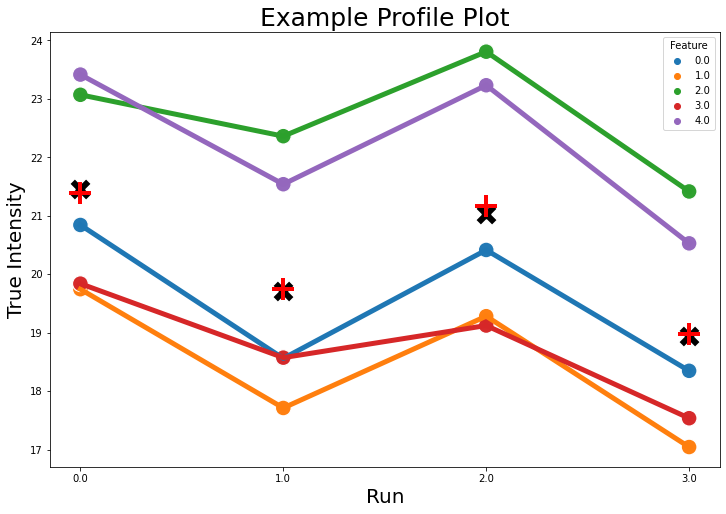

In [52]:
profile = simulator.data[simulator.data["Protein"] == 5.]
profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Run"] = profile.loc[:, "Run"].astype(str)
profile.loc[:, "Run_mean"] = profile.loc[:, "Protein_mean"] + profile.loc[:, "Run_effect"]
infer = profile.groupby("Run")["True_Intensity"].mean().reset_index()
infer = infer.rename(columns={"True_Intensity" : "infer_mean"})
profile = pd.merge(profile, infer, how="left", on="Run")

fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(data=profile, x="Run", y="True_Intensity", hue="Feature",ax=ax,lw=5, legend=False)
sns.scatterplot(data=profile, x="Run", y="True_Intensity", hue="Feature",ax=ax, s=250, alpha=.99)

sns.scatterplot(data=profile, x="Run", y="Run_mean",ax=ax, s=500, marker="X", legend=False, color="black")
sns.scatterplot(data=profile, x="Run", y="Run_mean",ax=ax, s=500, marker="X", legend=False, color="black")
sns.scatterplot(data=profile, x="Run", y="infer_mean",ax=ax, s=500, marker="+", legend=False, color="red",linewidth=3.5)


ax.set_title("Example Profile Plot",fontdict={'fontsize': 25})
ax.set_ylabel("True Intensity",fontdict={'fontsize': 20})
ax.set_xlabel("Run",fontdict={'fontsize': 20})

/tmp/ipykernel_15381/3391663102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_15381/3391663102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_15381/3391663102.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Text(0.5, 0, 'Run')

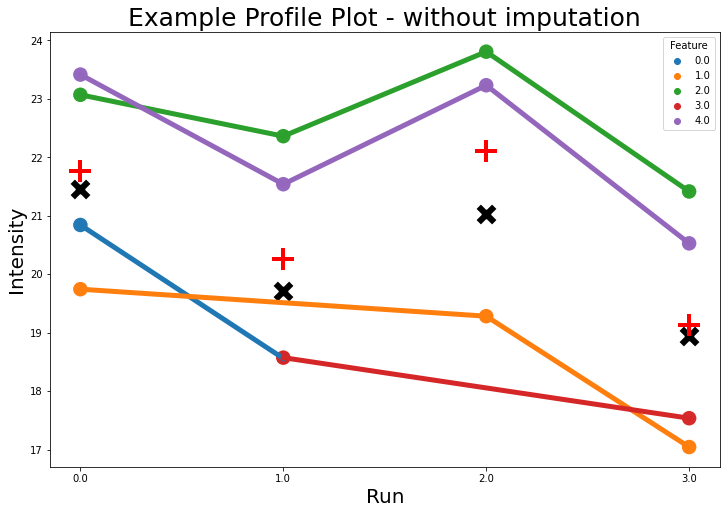

In [55]:
profile = simulator.data[simulator.data["Protein"] == 5.]
profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Run"] = profile.loc[:, "Run"].astype(str)
profile.loc[:, "Run_mean"] = profile.loc[:, "Protein_mean"] + profile.loc[:, "Run_effect"]
infer = profile.groupby("Run")["Intensity"].mean().reset_index()
infer = infer.rename(columns={"Intensity" : "infer_mean"})
profile = pd.merge(profile, infer, how="left", on="Run")

fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(data=profile, x="Run", y="Intensity", hue="Feature",ax=ax,lw=5, legend=False)
sns.scatterplot(data=profile, x="Run", y="Intensity", hue="Feature",ax=ax, s=250, alpha=.99)

sns.scatterplot(data=profile, x="Run", y="Run_mean",ax=ax, s=500, marker="X", legend=False, color="black")
sns.scatterplot(data=profile, x="Run", y="infer_mean",ax=ax, s=500, marker="+", legend=False, color="red",linewidth=3.5)


ax.set_title("Example Profile Plot - without imputation",fontdict={'fontsize': 25})
ax.set_ylabel("Intensity",fontdict={'fontsize': 20})
ax.set_xlabel("Run",fontdict={'fontsize': 20})

/tmp/ipykernel_15381/2409839404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_15381/2409839404.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_15381/2409839404.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Text(0.5, 0, 'Run')

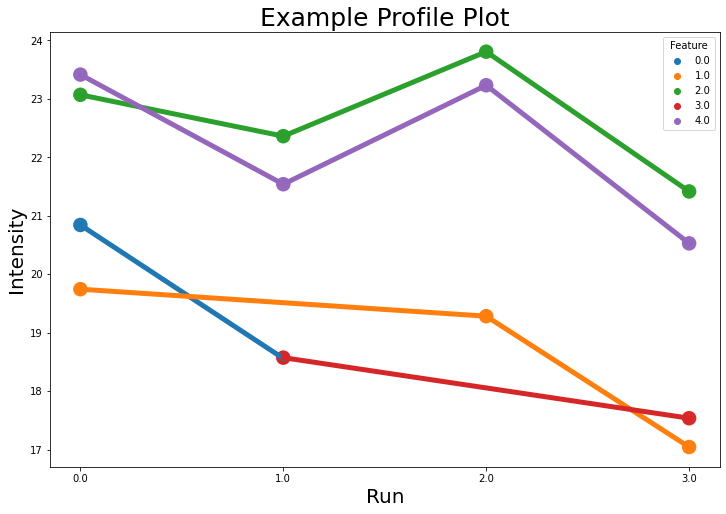

In [58]:
profile = simulator.data[simulator.data["Protein"] == 5.]
profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Run"] = profile.loc[:, "Run"].astype(str)
profile.loc[:, "Run_mean"] = profile.loc[:, "Protein_mean"] + profile.loc[:, "Run_effect"]
infer = profile.groupby("Run")["Intensity"].mean().reset_index()
infer = infer.rename(columns={"Intensity" : "infer_mean"})
profile = pd.merge(profile, infer, how="left", on="Run")

fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(data=profile, x="Run", y="Intensity", hue="Feature",ax=ax,lw=5, legend=False)
sns.scatterplot(data=profile, x="Run", y="Intensity", hue="Feature",ax=ax, s=250, alpha=.99)

ax.set_title("Example Profile Plot",fontdict={'fontsize': 25})
ax.set_ylabel("Intensity",fontdict={'fontsize': 20})
ax.set_xlabel("Run",fontdict={'fontsize': 20})

/tmp/ipykernel_15381/3389833845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_15381/3389833845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_15381/3389833845.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Text(0.5, 0, 'Run')

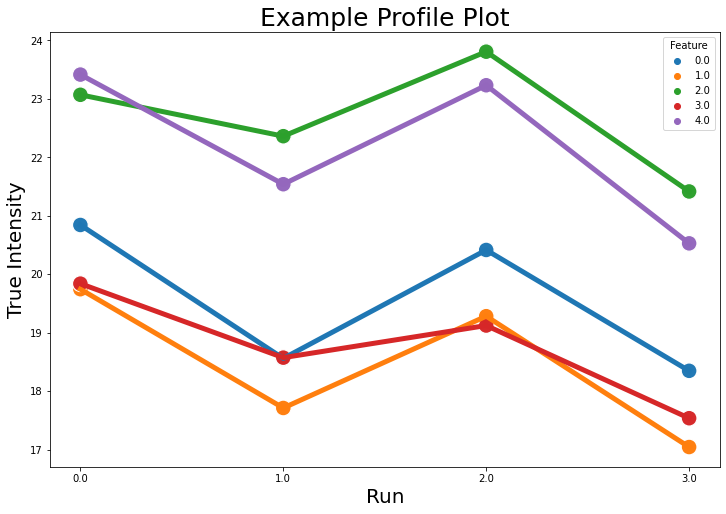

In [59]:
profile = simulator.data[simulator.data["Protein"] == 5.]
profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Run"] = profile.loc[:, "Run"].astype(str)
profile.loc[:, "Run_mean"] = profile.loc[:, "Protein_mean"] + profile.loc[:, "Run_effect"]
infer = profile.groupby("Run")["True_Intensity"].mean().reset_index()
infer = infer.rename(columns={"True_Intensity" : "infer_mean"})
profile = pd.merge(profile, infer, how="left", on="Run")

fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(data=profile, x="Run", y="True_Intensity", hue="Feature",ax=ax,lw=5, legend=False)
sns.scatterplot(data=profile, x="Run", y="True_Intensity", hue="Feature",ax=ax, s=250, alpha=.99)


ax.set_title("Example Profile Plot",fontdict={'fontsize': 25})
ax.set_ylabel("True Intensity",fontdict={'fontsize': 20})
ax.set_xlabel("Run",fontdict={'fontsize': 20})